In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
import lightgbm as lgb


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import pickle

In [2]:
data=pd.read_excel("data.xlsx")
data.head()

,Client,Unnamed: 1,Unnamed: 2,Contract,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Scoring,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Collection,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Computed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CNP,Gender,Age,DataSemnarii,DataInchis,Number,Produs,CreditLimit,State,scoringdate,...,PenguinIgnoringBNR,DolphinIgnoringBNR,ClientCategory,Comission,Withdrawed,DpdDiffDaysMax,DpdTotal,PaidTotal,FutureTotal,IsDerrogationBNR
2,1900226063350,M,32,2021-10-15 18:37:54,2021-10-16 18:11:03,DK53851057,Penguin,1900,Inchis,2021-10-15 00:31:13,...,0,0,0,0,-1900,-27,0,1907.56,0,NaN
3,1900226063350,M,32,2021-11-06 03:38:12,2021-12-10 12:29:02,TC42768422,Penguin,700,Inchis,2021-10-15 00:31:13,...,0,0,0,0,-700,-22,0,783.58,0,NaN
4,1811228048420,M,41,2021-10-15 10:43:41,2022-01-14 16:20:02,HP51173676,Penguin,2000,Inchis,2021-10-15 07:34:50,...,0,0,0,0,-2000,3,0,2239.08,0,NaN


In [3]:
data.columns = data.iloc[1]

In [4]:
dataset=data.drop([0,1], inplace=False)
dataset=data.reset_index()
dataset=data.drop(data.columns[0],axis=1)

In [5]:
df=data.drop([0,1], inplace=False)
df=df.reset_index()
df=df.drop(df.columns[0],axis=1)

In [6]:
df=df.drop(['CNP','Number'],axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12516 entries, 0 to 12515
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Gender              12516 non-null  object
 1   Age                 12516 non-null  object
 2   DataSemnarii        12516 non-null  object
 3   DataInchis          6827 non-null   object
 4   Produs              12516 non-null  object
 5   CreditLimit         12516 non-null  object
 6   State               12516 non-null  object
 7   scoringdate         12516 non-null  object
 8   score               12516 non-null  object
 9   ProbabilityOfModel  12516 non-null  object
 10  DeclIncome          12516 non-null  object
 11  ANAFIncome          12516 non-null  object
 12  TotalLoanPayments   12516 non-null  object
 13  BNR40Available      12516 non-null  object
 14  CreditsBefore       12516 non-null  object
 15  OfferCrab           12516 non-null  object
 16  OfferPenguin        12

In [8]:
df['DataInchis']=pd.to_datetime(df['DataInchis'])
df['DataSemnarii']=pd.to_datetime(df['DataSemnarii'])
df['scoringdate']=pd.to_datetime(df['scoringdate'])

In [9]:
numeric_columns=['Age','CreditLimit','score','ProbabilityOfModel','DeclIncome','ANAFIncome','TotalLoanPayments','BNR40Available',
                 'CreditsBefore','OfferCrab','OfferPenguin','OfferDolphin','CrabIgnoringBNR','PenguinIgnoringBNR','DolphinIgnoringBNR',
                 'ClientCategory','Comission','Withdrawed','DpdDiffDaysMax','DpdTotal','PaidTotal','FutureTotal']

In [10]:
for column in numeric_columns:
    df[column]=pd.to_numeric(df[column])

In [11]:
object_values=[]
ob_coll=df.select_dtypes(object).columns
for column in ob_coll:
     object_values.append(np.count_nonzero(df[column].value_counts()))

In [12]:
df['IsDerrogationBNR']=df['IsDerrogationBNR'].fillna(False)

In [13]:
df = df[df['State'] != 'Moneysend']


In [14]:
max_datetime = df['DataInchis'].max()
df.loc[df['DataInchis'].isnull() , 'durata_contract']=(max_datetime - df['DataSemnarii']).dt.days
df.loc[df['DataInchis'].notnull() , 'durata_contract']=(df['DataInchis'] - df['DataSemnarii']).dt.days

In [15]:
df.loc[(df['IsDerrogationBNR'] ==False)&((df['durata_contract'] > 60) & (df['DpdDiffDaysMax'] >= 50)), 'target']=1    

In [16]:
df.loc[df['DpdDiffDaysMax'] < 30,'target']=0 # clientiti buni

In [17]:
df=df.drop(['DataInchis','DataSemnarii','scoringdate','State'],axis=1)

In [18]:
df=df.dropna()

In [19]:
object_values=[]
ob_coll=df.select_dtypes(object).columns
for column in ob_coll:
     object_values.append(np.count_nonzero(df[column].value_counts()))

In [20]:
lbl_enc=LabelEncoder()
df[ob_coll]=df[ob_coll].astype(str).apply(lbl_enc.fit_transform)

<AxesSubplot:xlabel='1', ylabel='1'>

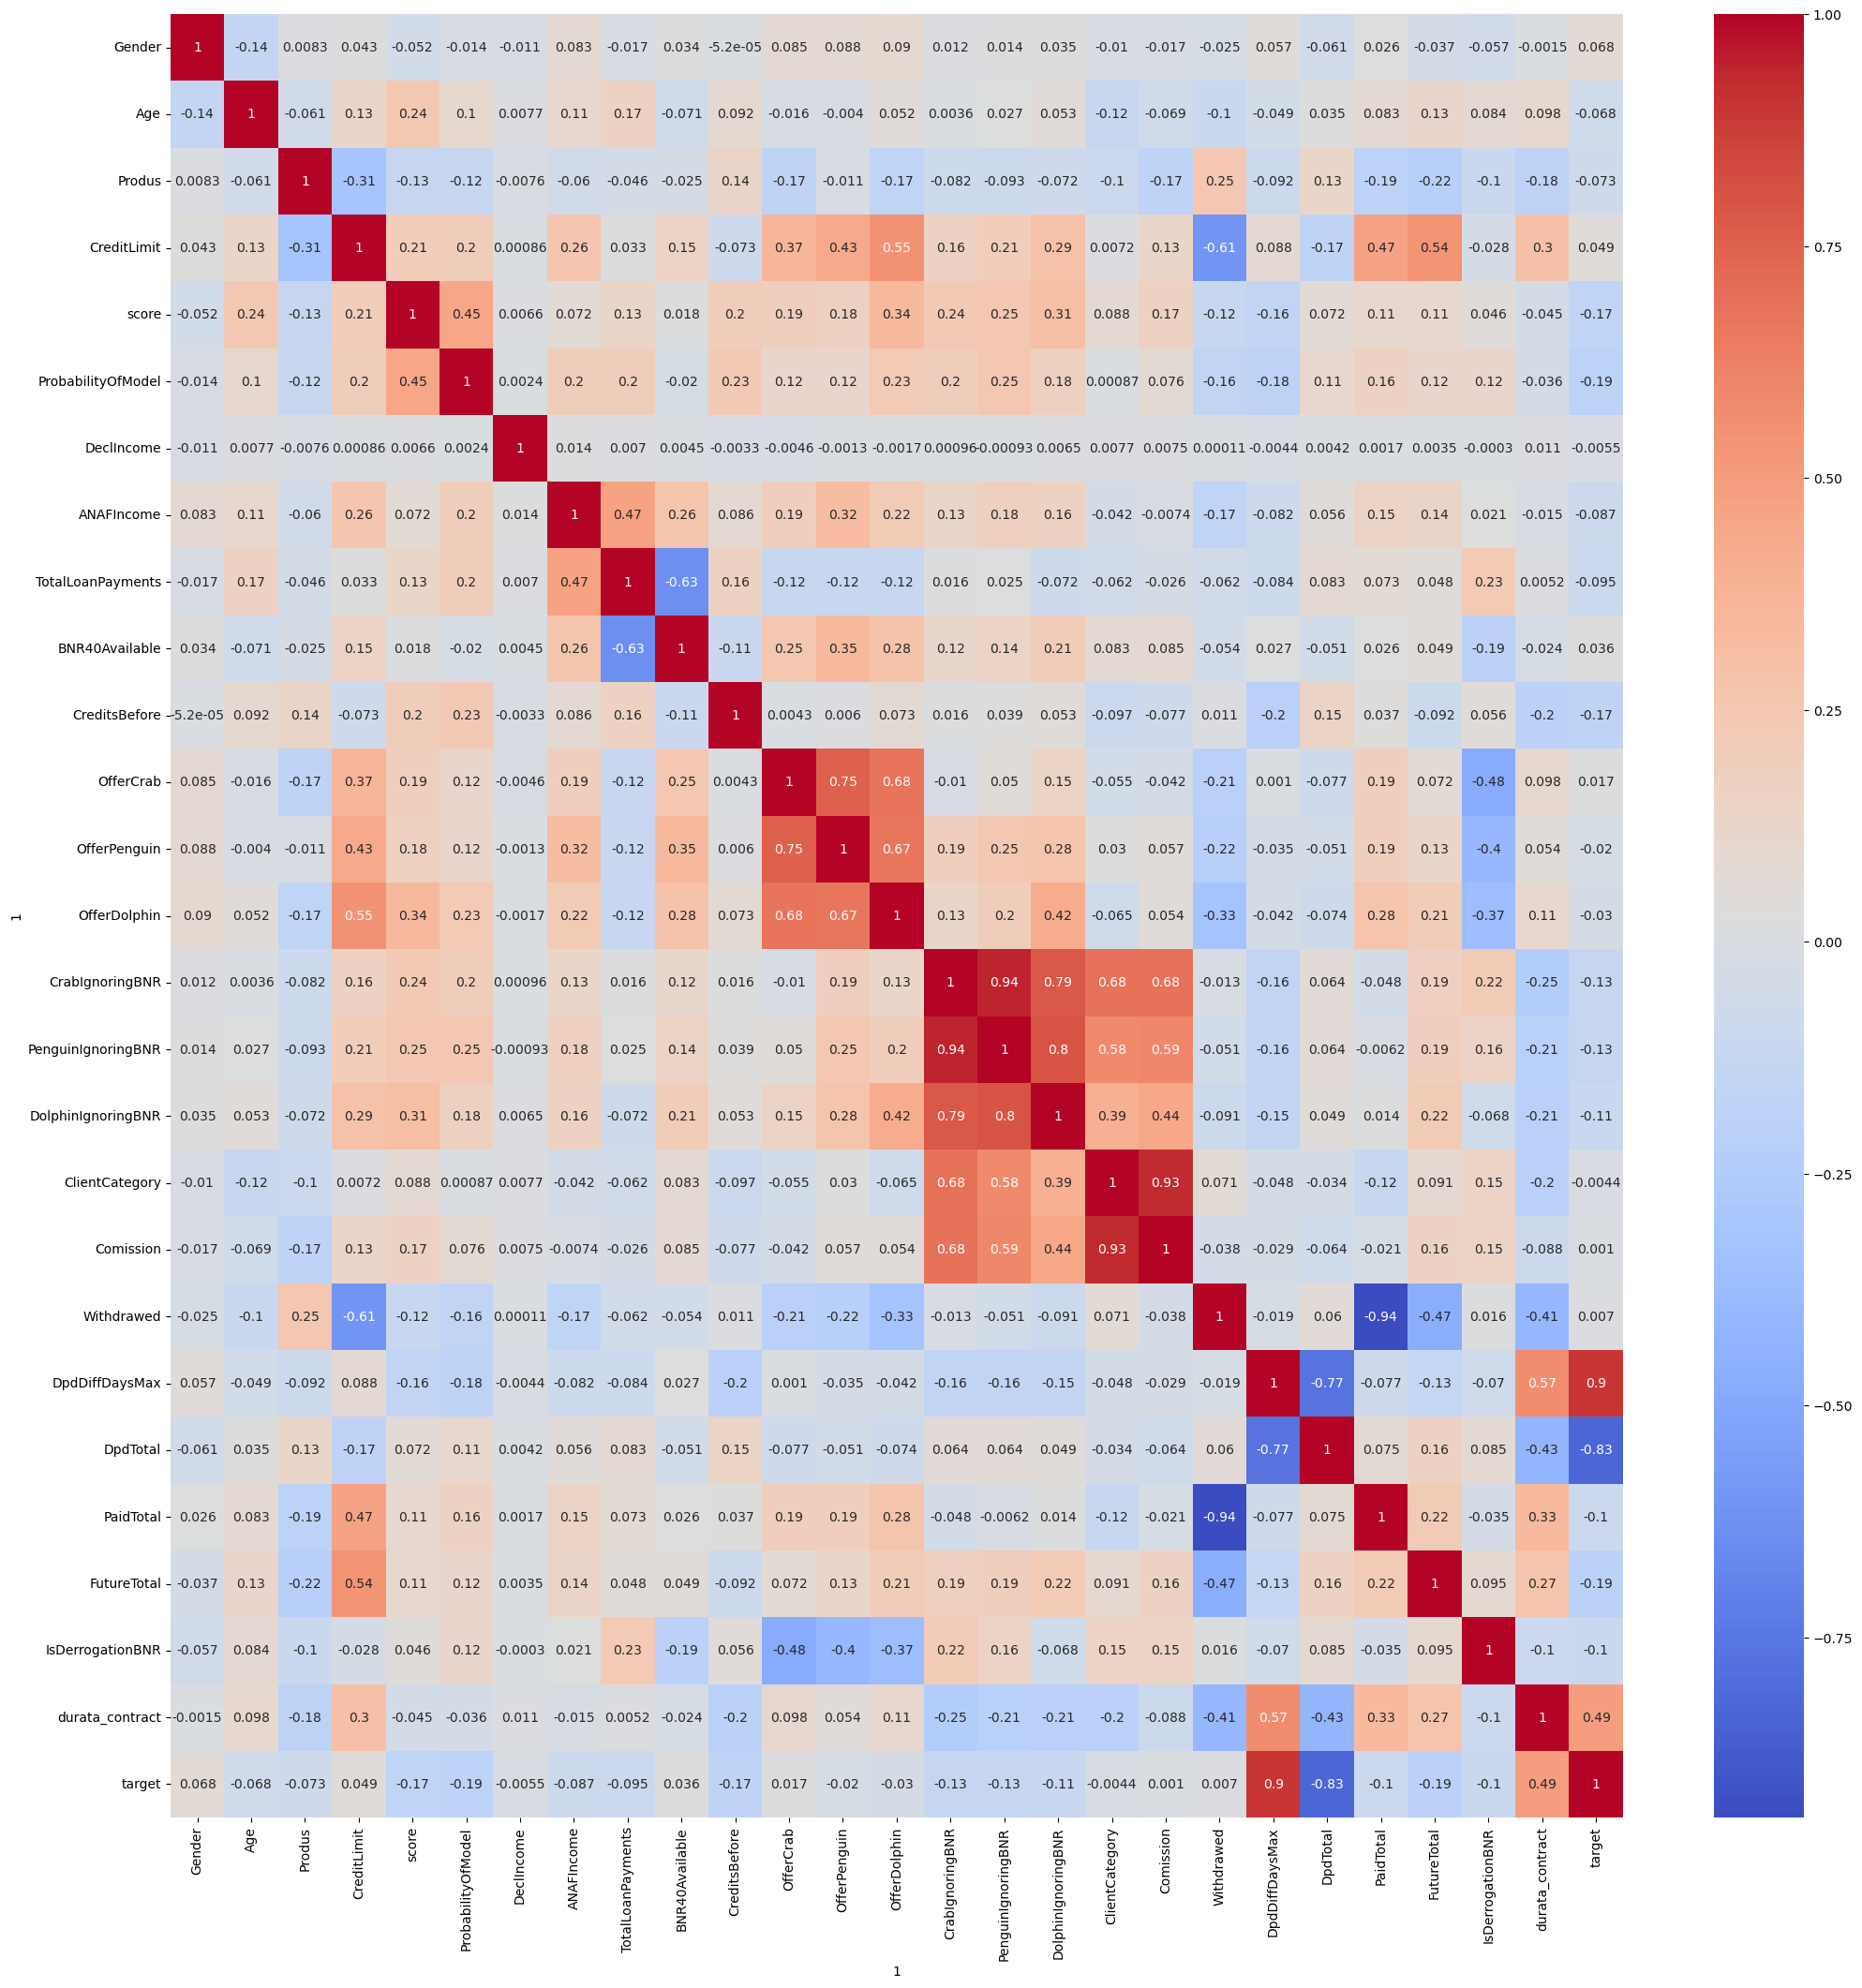

In [21]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

#### Features that contain information about the future will not be included in building the model since those events are yet to occur. The features include next_pymnt_d, recoveries, collection_recovery_fee, total_rec_prncp and total_rec_late_fee

In [22]:
df.columns

Index(['Gender', 'Age', 'Produs', 'CreditLimit', 'score', 'ProbabilityOfModel',
       'DeclIncome', 'ANAFIncome', 'TotalLoanPayments', 'BNR40Available',
       'CreditsBefore', 'OfferCrab', 'OfferPenguin', 'OfferDolphin',
       'CrabIgnoringBNR', 'PenguinIgnoringBNR', 'DolphinIgnoringBNR',
       'ClientCategory', 'Comission', 'Withdrawed', 'DpdDiffDaysMax',
       'DpdTotal', 'PaidTotal', 'FutureTotal', 'IsDerrogationBNR',
       'durata_contract', 'target'],
      dtype='object', name=1)

In [23]:
df=df.drop(['IsDerrogationBNR','ClientCategory','DeclIncome','DpdDiffDaysMax','DpdTotal','ProbabilityOfModel','Withdrawed', 'PaidTotal', 'FutureTotal','durata_contract'],axis=1)

In [24]:
df.loc[df['score']==0,['score']]=-1

In [25]:
X=df.drop('target',axis=1)
y=df['target']

<AxesSubplot:xlabel='1', ylabel='1'>

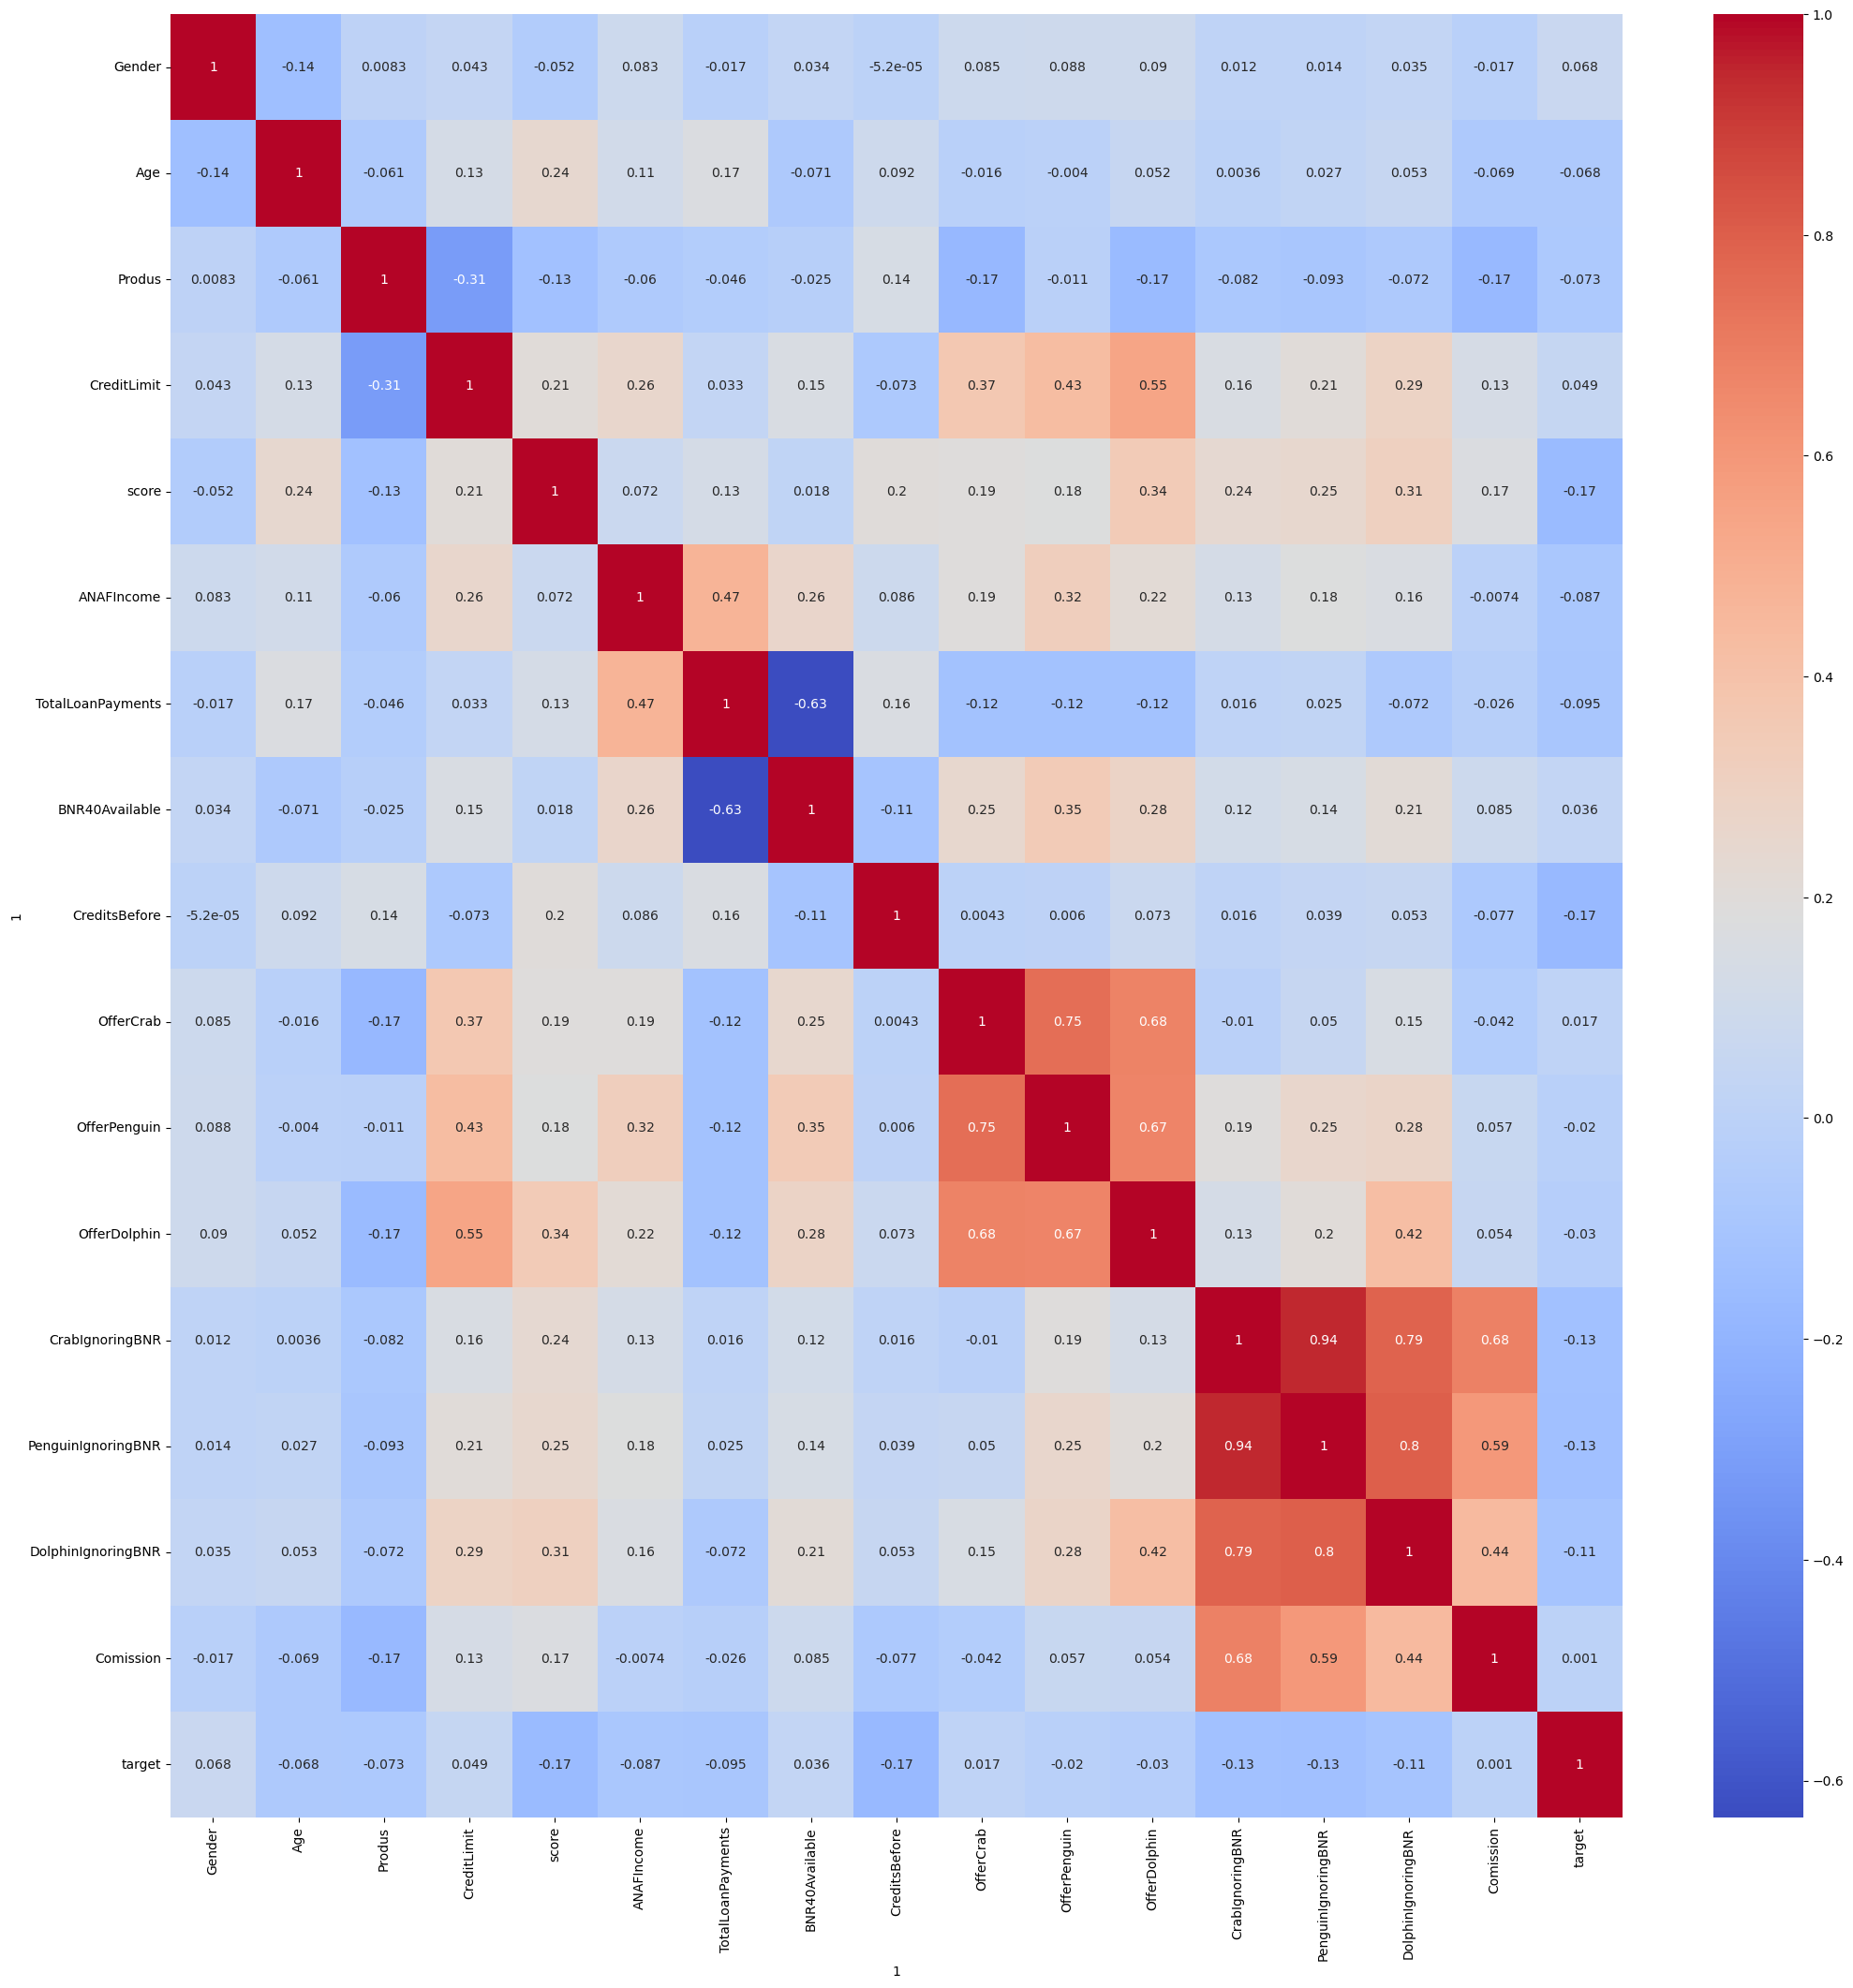

In [26]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

In [27]:
df.head()

1,Gender,Age,Produs,CreditLimit,score,ANAFIncome,TotalLoanPayments,BNR40Available,CreditsBefore,OfferCrab,OfferPenguin,OfferDolphin,CrabIgnoringBNR,PenguinIgnoringBNR,DolphinIgnoringBNR,Comission,target
0,1,32,2,1900,589,4980,1283,709,6,600,1900,3000,0,0,0,0,0.0
1,1,32,2,700,589,4980,1283,709,7,600,1900,3000,0,0,0,0,0.0
2,1,41,2,2000,608,4868,2847,-2847,7,700,2000,3000,0,0,0,0,0.0
3,0,40,2,700,581,4888,3360,-1404,2,200,700,0,0,0,0,0,0.0
4,1,33,0,900,590,7784,1031,2082,3,1000,4500,6000,0,0,0,0,0.0


In [28]:
df.describe()

1,Gender,Age,Produs,CreditLimit,score,ANAFIncome,TotalLoanPayments,BNR40Available,CreditsBefore,OfferCrab,OfferPenguin,OfferDolphin,CrabIgnoringBNR,PenguinIgnoringBNR,DolphinIgnoringBNR,Comission,target
count,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000,12110.000000
mean,0.663501,33.666309,1.370190,2639.983485,548.264822,4575.963749,1229.222874,318.028654,3.747564,600.338481,1922.435921,3120.148637,593.047069,2176.168456,2909.801817,6.076879,0.103881
std,0.472531,8.940580,0.599463,1915.686255,121.332714,3473.059256,1757.744168,1724.218457,5.663634,361.650566,1351.880532,2512.918867,455.938198,1828.886189,2672.907023,3.495398,0.305119
min,0.000000,18.000000,0.000000,500.000000,-1.000000,0.000000,0.000000,-101462.000000,0.000000,-1000.000000,-100.000000,0.000000,-1000.000000,-3000.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,1.000000,1000.000000,522.000000,2845.000000,277.000000,-108.000000,0.000000,300.000000,800.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,1.000000,32.000000,1.000000,2400.000000,559.000000,3857.500000,859.000000,404.000000,1.000000,700.000000,1700.000000,3100.000000,800.000000,2400.000000,3200.000000,7.000000,0.000000
75%,1.000000,39.000000,2.000000,4000.000000,603.000000,5285.000000,1670.750000,944.000000,5.000000,1000.000000,2900.000000,4000.000000,1000.000000,4100.000000,4000.000000,9.000000,0.000000
max,1.000000,74.000000,2.000000,9000.000000,798.000000,122794.000000,103920.000000,35720.000000,59.000000,1500.000000,4500.000000,9000.000000,1500.000000,4500.000000,9000.000000,9.000000,1.000000


In [29]:
preprocess_data = df

In [30]:
#function to calculate Weight of Evidence (WoE) and Information Value (IV)

def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = df.columns
    
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(preprocess_data, target='target', bins=20)

Information value of Gender is 0.054355
Information value of Age is 0.123033
Information value of Produs is 0.175646
Information value of CreditLimit is 0.337011
Information value of score is 0.718163
Information value of ANAFIncome is 0.239865
Information value of TotalLoanPayments is 0.298961
Information value of BNR40Available is 0.216159
Information value of CreditsBefore is 0.770507
Information value of OfferCrab is 0.048885
Information value of OfferPenguin is 0.074703
Information value of OfferDolphin is 0.38133
Information value of CrabIgnoringBNR is 0.219921
Information value of PenguinIgnoringBNR is 0.350281
Information value of DolphinIgnoringBNR is 0.688544
Information value of Comission is 0.161527


#### The rule of thumb says that all variables with IV < 0.02 are not useful for prediction and IV > 0.5 have a suspicious predictive power.

In [31]:
#df=df.drop(['DolphinIgnoringBNR','PenguinIgnoringBNR','CrabIgnoringBNR','CreditsBefore'])

In [32]:
selected_columns =[]
for column in X.columns:
    if X[column].unique().size>5:
        selected_columns.append(column)
X_selected = X[selected_columns]
X_selected=X_selected.select_dtypes(exclude=['datetime','object','bool']).columns
skew_limit = 0.75

skew_vals = X[X_selected].skew()
skew_cols = skew_vals[abs(skew_vals) > skew_limit]
skew_cols = skew_cols.rename('Skew')
skewed_columns = skew_cols.index.tolist()
skew_cols.sort_values(ascending=False)

1
TotalLoanPayments    21.233702
ANAFIncome           11.574376
CreditsBefore         2.565252
CreditLimit           1.106157
Age                   0.832429
score                -3.156266
BNR40Available      -18.415878
Name: Skew, dtype: float64

In [33]:
# df_norm=df
# for col in skewed_columns:
#     df_norm[col] = np.cbrt(df[col])

In [34]:
preprocess_data_norm = df

In [35]:
iv, woe = iv_woe(preprocess_data_norm, target='target', bins=10)

Information value of Gender is 0.054355
Information value of Age is 0.095967
Information value of Produs is 0.175646
Information value of CreditLimit is 0.293811
Information value of score is 0.69846
Information value of ANAFIncome is 0.21505
Information value of TotalLoanPayments is 0.287577
Information value of BNR40Available is 0.198612
Information value of CreditsBefore is 0.769164
Information value of OfferCrab is 0.043488
Information value of OfferPenguin is 0.061582
Information value of OfferDolphin is 0.319519
Information value of CrabIgnoringBNR is 0.201601
Information value of PenguinIgnoringBNR is 0.195554
Information value of DolphinIgnoringBNR is 0.688544
Information value of Comission is 0.161527


In [36]:
df=df.drop(['DolphinIgnoringBNR','PenguinIgnoringBNR','CrabIgnoringBNR','CreditsBefore'],axis=1)

In [37]:
dummy_df_pr = pd.get_dummies(dataset['Produs'])
dummy_df_gn = pd.get_dummies(dataset['Gender'])
df_dm= pd.concat([df, dummy_df_pr,dummy_df_gn], axis=1)
df_dm=df_dm.drop(["Produs","Gender"],axis=1)

In [38]:
def woe_categorical(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [39]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 12))
    plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [40]:
X= df.drop(columns='target', axis=1)
y=df['target']

In [41]:
X.head()

1,Gender,Age,Produs,CreditLimit,score,ANAFIncome,TotalLoanPayments,BNR40Available,OfferCrab,OfferPenguin,OfferDolphin,Comission
0,1,32,2,1900,589,4980,1283,709,600,1900,3000,0
1,1,32,2,700,589,4980,1283,709,600,1900,3000,0
2,1,41,2,2000,608,4868,2847,-2847,700,2000,3000,0
3,0,40,2,700,581,4888,3360,-1404,200,700,0,0
4,1,33,0,900,590,7784,1031,2082,1000,4500,6000,0


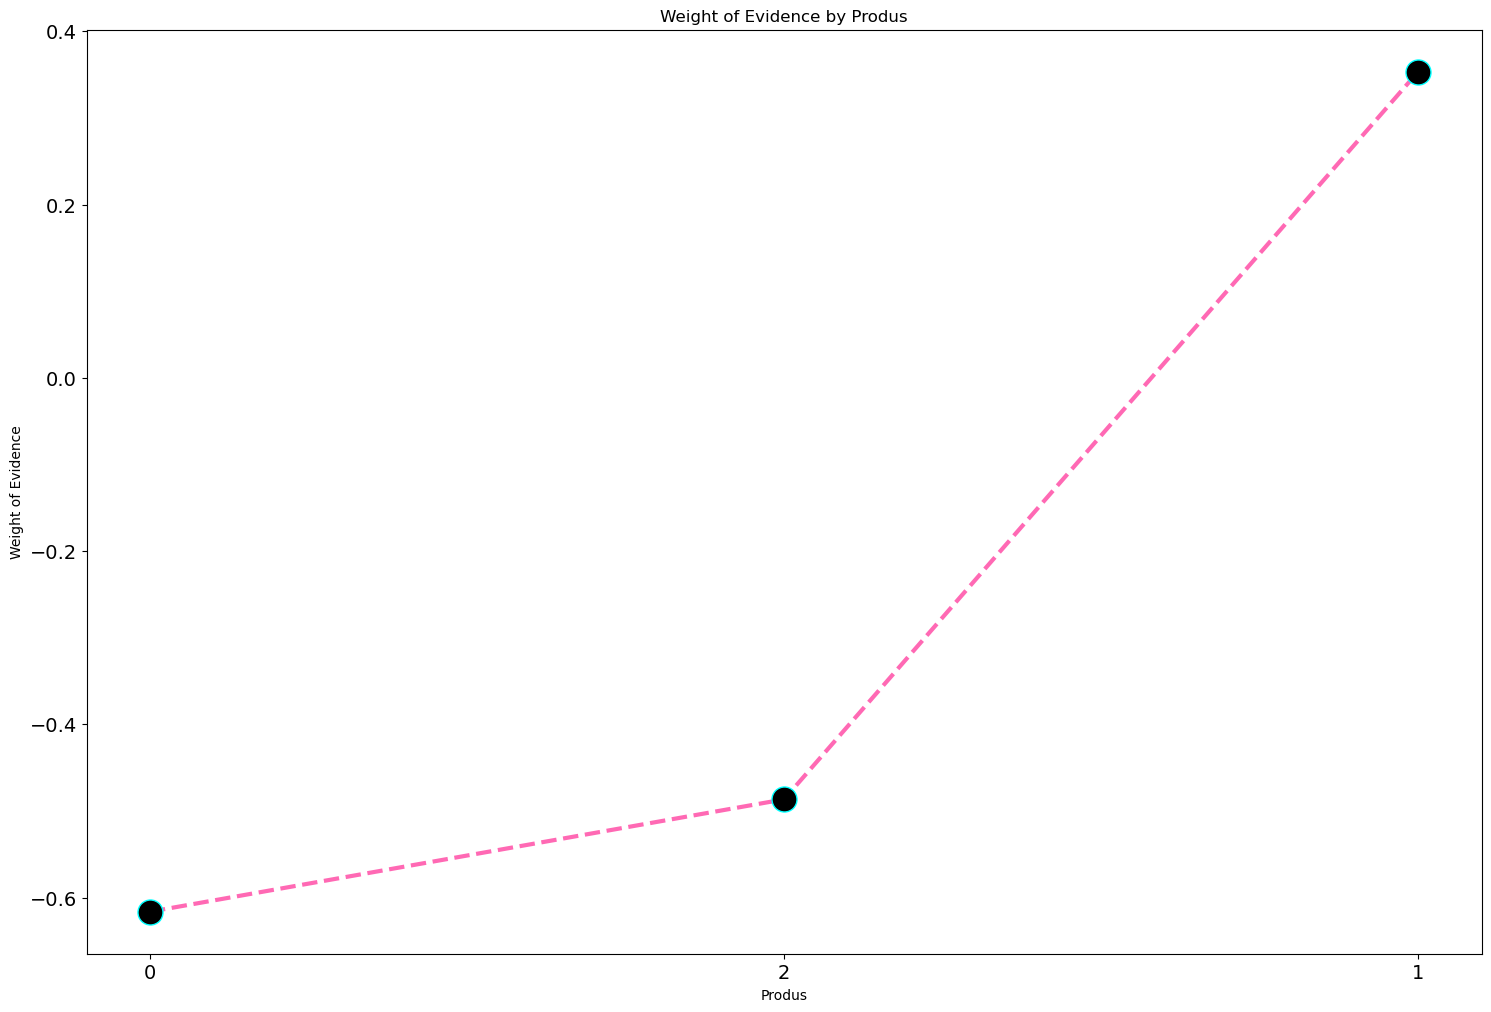

In [42]:
df_grade = woe_categorical(X, 'Produs', y)
plot_by_woe(df_grade)

In [43]:
dataset['Produs'].value_counts()

Dolphin    6412
Penguin    5332
Crab        772
Produs        1
Name: Produs, dtype: int64

In [44]:
df["Produs"].value_counts()

1    6099
2    5247
0     764
Name: Produs, dtype: int64

### 1-Dolphin    2-Penguin  0-Crab


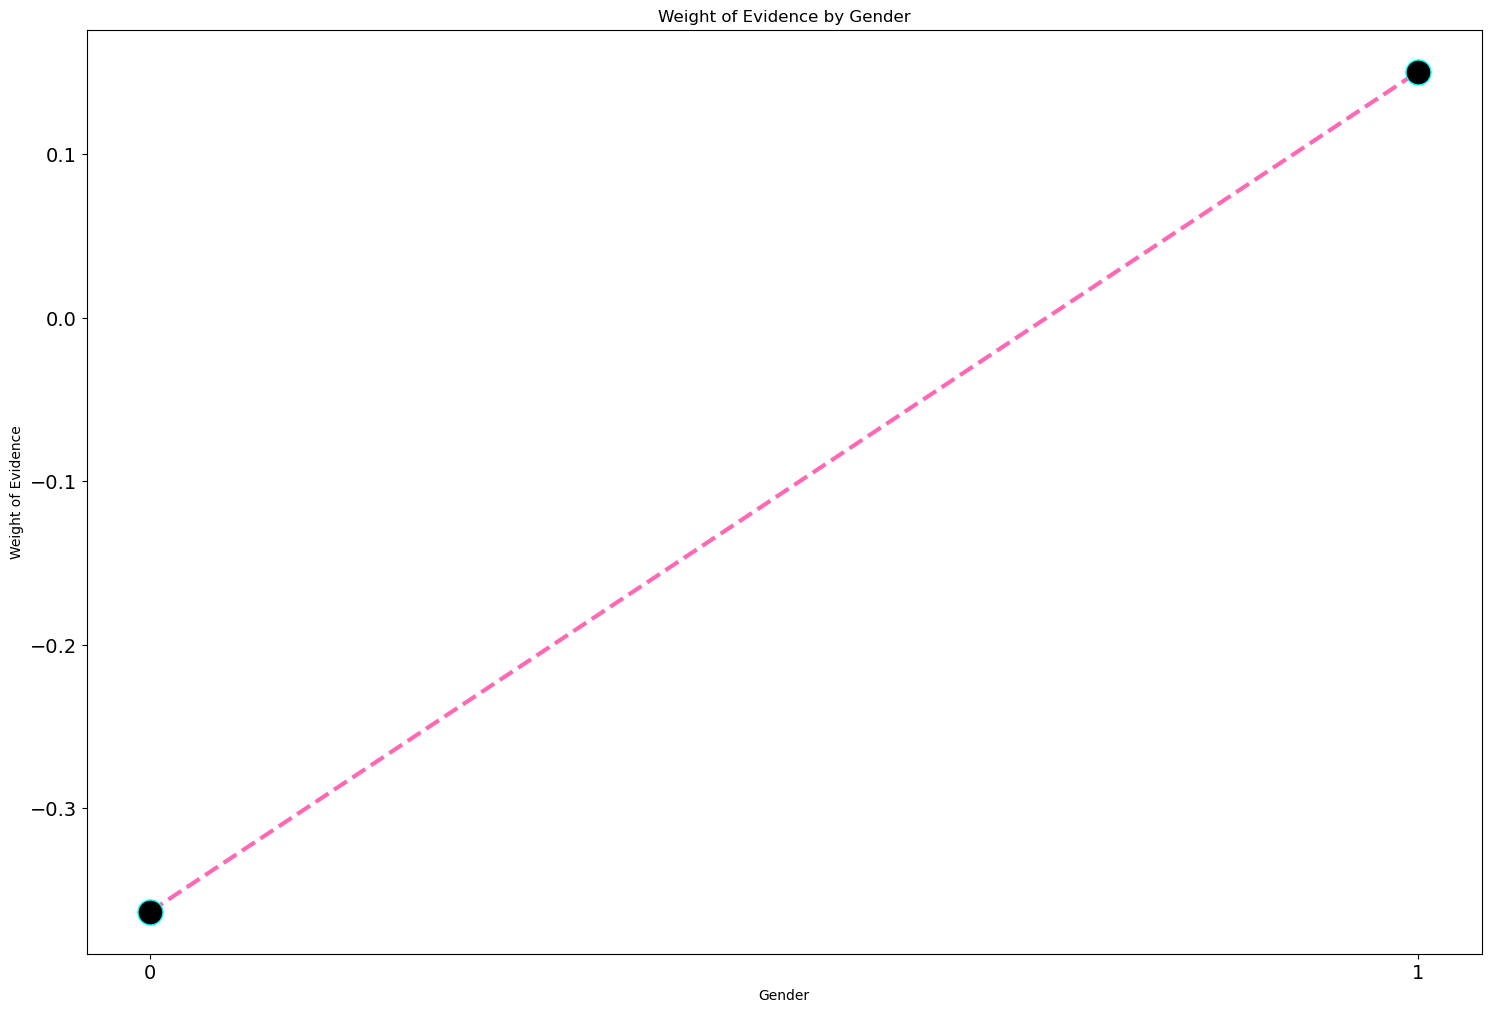

In [45]:
df_grade = woe_categorical(X, 'Gender', y)
plot_by_woe(df_grade)

In [46]:
def woe_continous(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [47]:
# fig, ax = plt.subplots(figsize =(20, 65))
# i=0
# for column in df.columns:
#     plt.subplot(10, 2, i+1)
#     i+=1
#     plot_by_woe(woe_continous(X,column, y ))
# plt.show

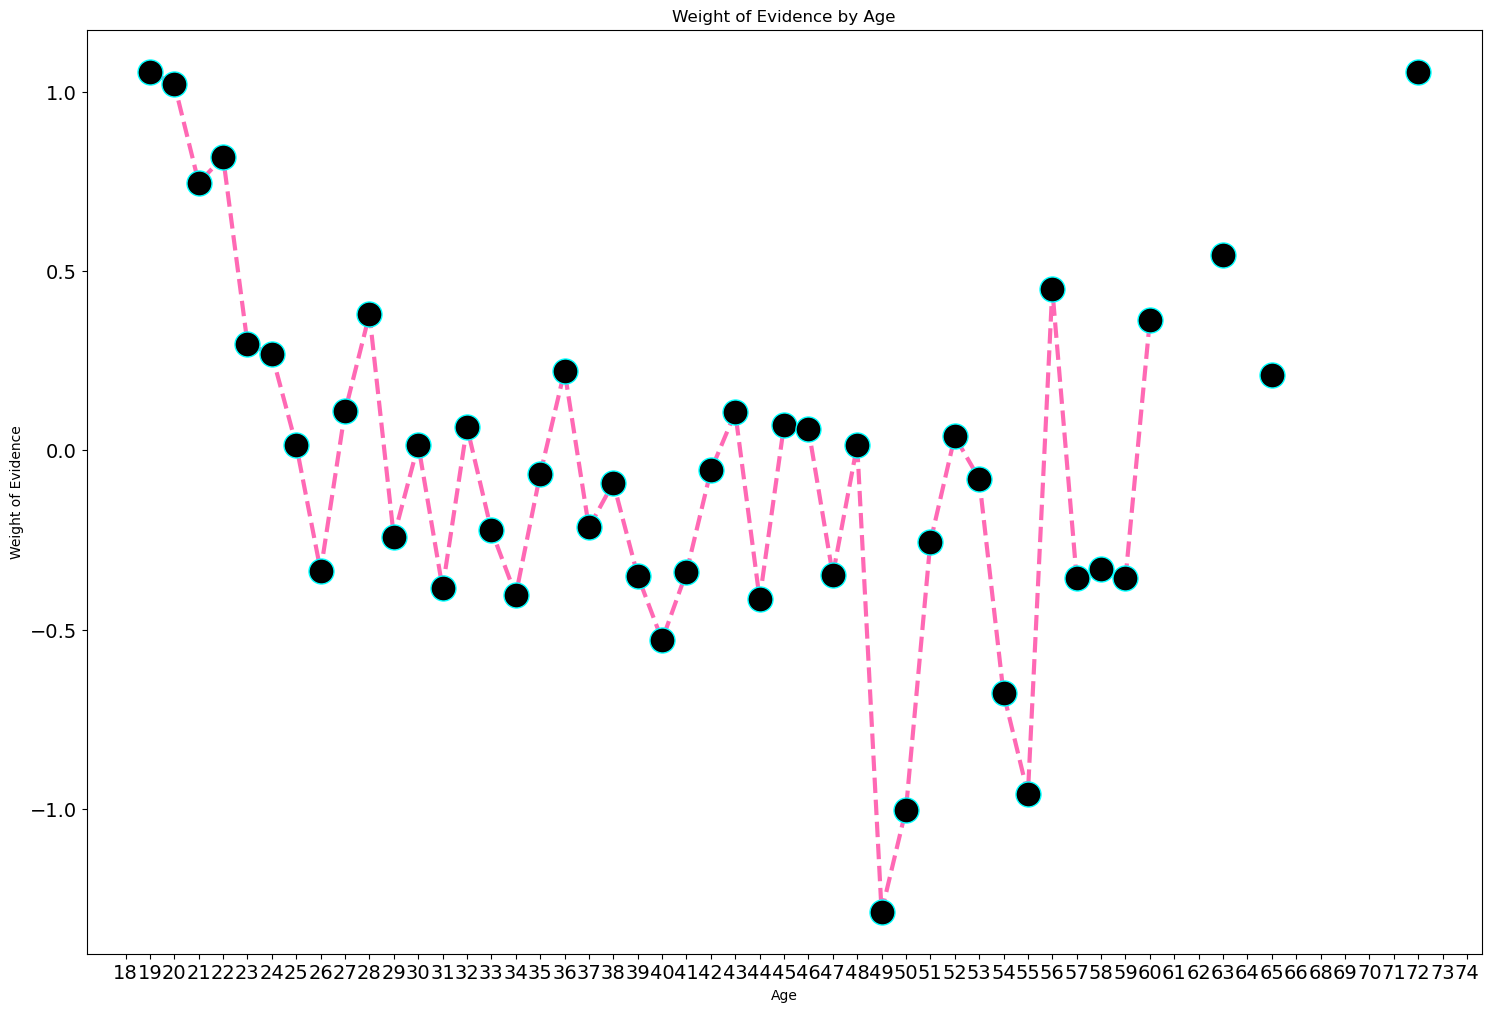

In [48]:
plot_by_woe(woe_continous(X,'Age', y ))

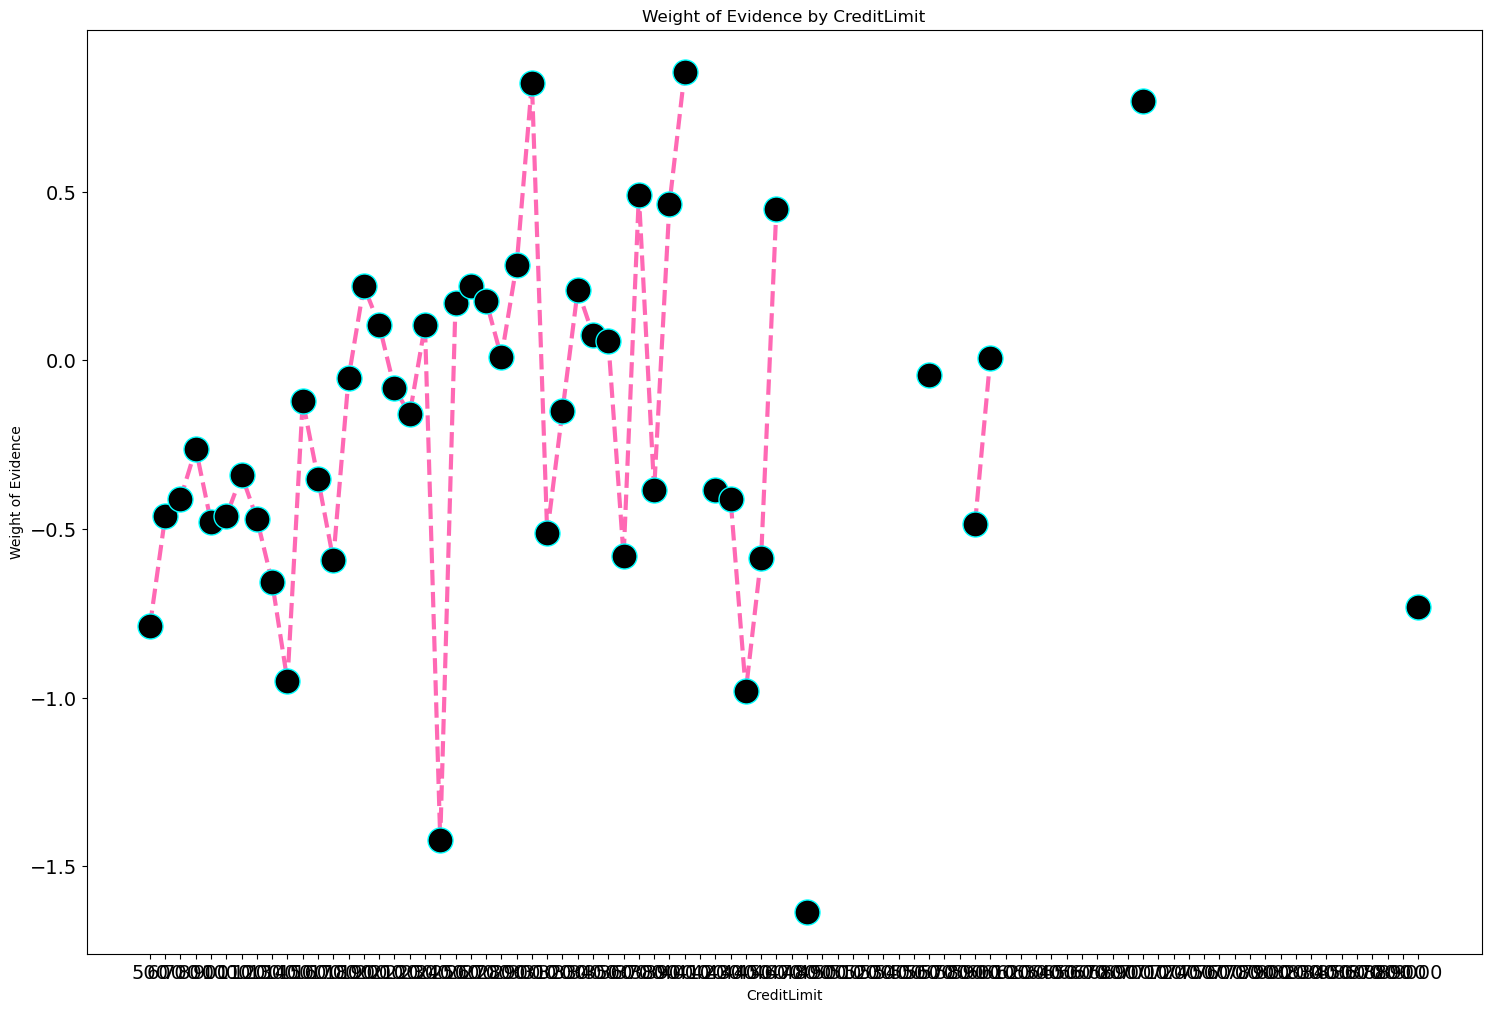

In [49]:
plot_by_woe(woe_continous(X,'CreditLimit', y ))

In [50]:
X.columns

Index(['Gender', 'Age', 'Produs', 'CreditLimit', 'score', 'ANAFIncome',
       'TotalLoanPayments', 'BNR40Available', 'OfferCrab', 'OfferPenguin',
       'OfferDolphin', 'Comission'],
      dtype='object', name=1)

In [51]:
iv, woe = iv_woe(preprocess_data_norm, target='target', bins=5)
woe

Information value of Gender is 0.054355
Information value of Age is 0.052425
Information value of Produs is 0.175646
Information value of CreditLimit is 0.20095
Information value of score is 0.677816
Information value of ANAFIncome is 0.18633
Information value of TotalLoanPayments is 0.282203
Information value of BNR40Available is 0.132025
Information value of OfferCrab is 0.017529
Information value of OfferPenguin is 0.050229
Information value of OfferDolphin is 0.177913
Information value of Comission is 0.161527


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Gender,0,4075,304.0,0.241653,3771.0,0.347494,-0.363242,0.038446
1,Gender,1,8035,954.0,0.758347,7081.0,0.652506,0.150319,0.015910
0,Age,"(17.999, 26.0]",2836,397.0,0.315580,2439.0,0.224751,0.339419,0.030829
1,Age,"(26.0, 30.0]",2226,246.0,0.195548,1980.0,0.182455,0.069306,0.000907
2,Age,"(30.0, 34.0]",2320,196.0,0.155803,2124.0,0.195724,-0.228115,0.009107
3,Age,"(34.0, 41.0]",2474,225.0,0.178855,2249.0,0.207243,-0.147314,0.004182
4,Age,"(41.0, 74.0]",2254,194.0,0.154213,2060.0,0.189827,-0.207777,0.007400
0,Produs,0,764,45.0,0.035771,719.0,0.066255,-0.616373,0.018790
1,Produs,1,6099,864.0,0.686804,5235.0,0.482400,0.353277,0.072212
2,Produs,2,5247,349.0,0.277424,4898.0,0.451345,-0.486684,0.084645


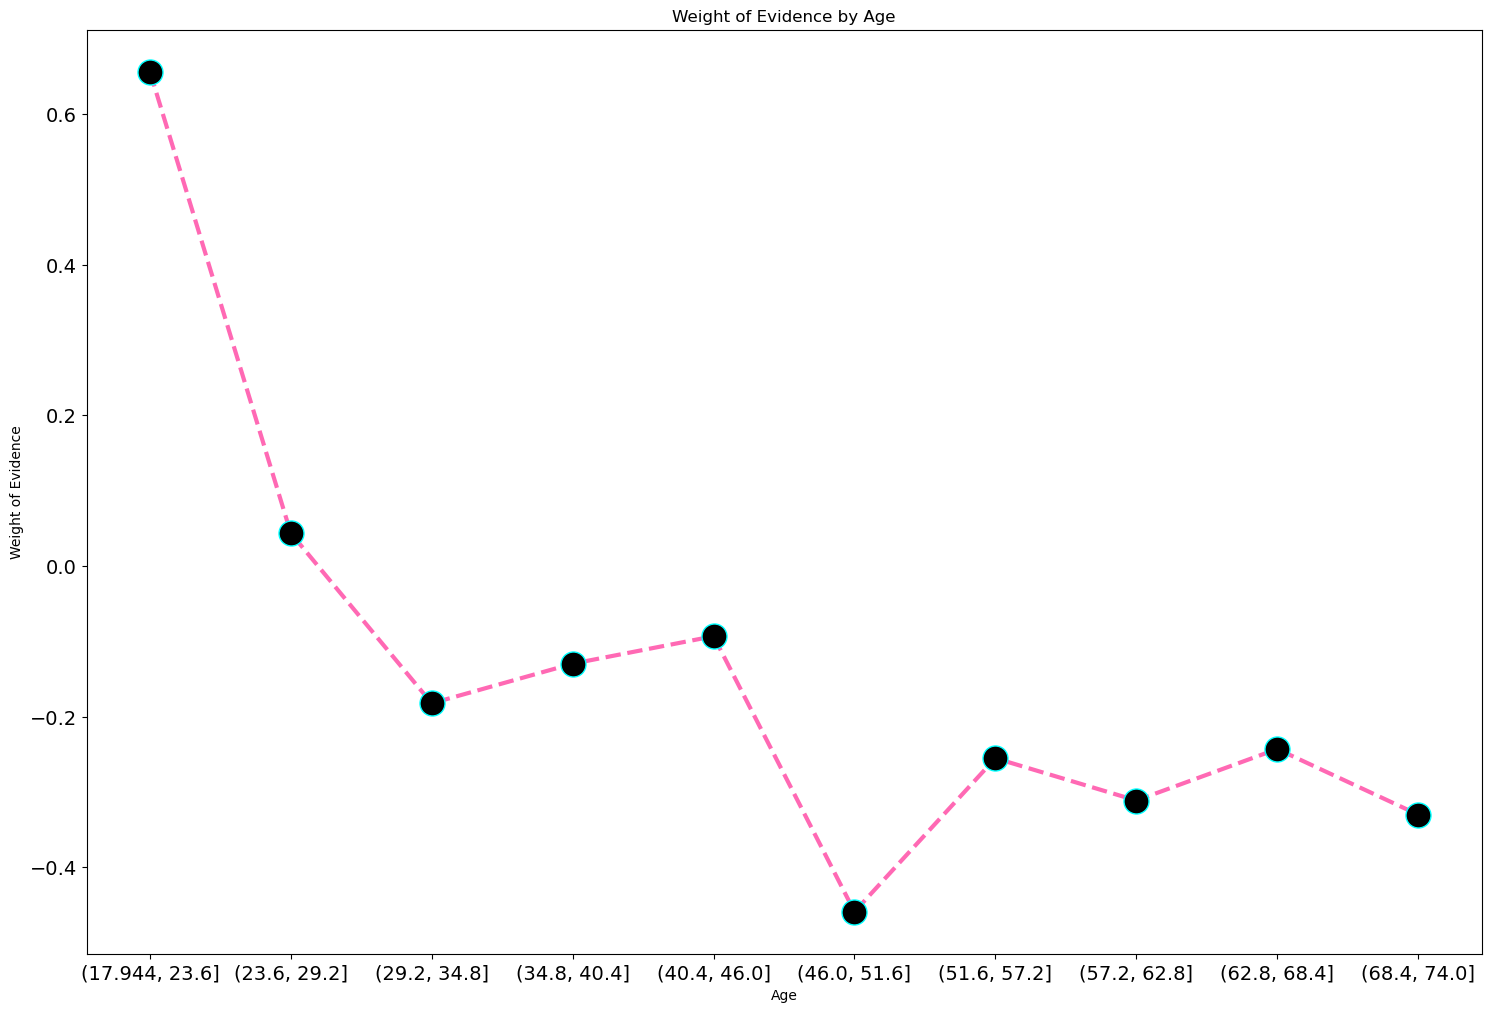

In [52]:
X['Age'] = pd.cut(df['Age'], 10)
age_iss_df = woe_continous(X, 'Age', y)
plot_by_woe(age_iss_df)

In [53]:
X.columns

Index(['Gender', 'Age', 'Produs', 'CreditLimit', 'score', 'ANAFIncome',
       'TotalLoanPayments', 'BNR40Available', 'OfferCrab', 'OfferPenguin',
       'OfferDolphin', 'Comission'],
      dtype='object', name=1)

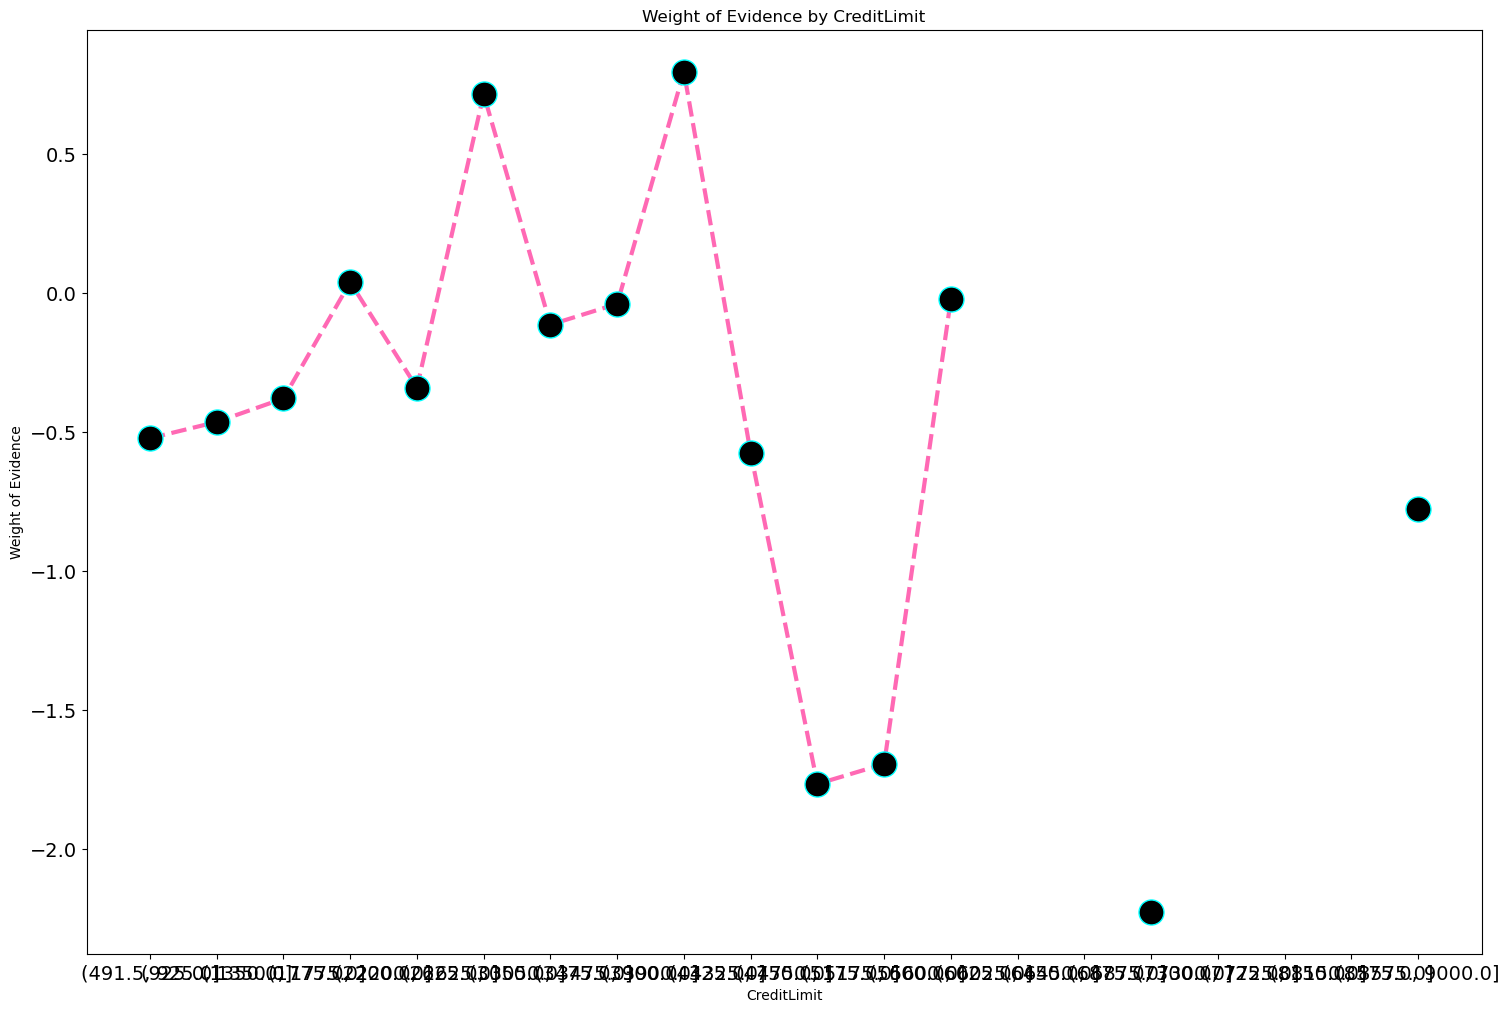

In [54]:
X['CreditLimit'] = pd.cut(df['CreditLimit'], 20)
age_iss_df = woe_continous(X, 'CreditLimit', y)
plot_by_woe(age_iss_df)

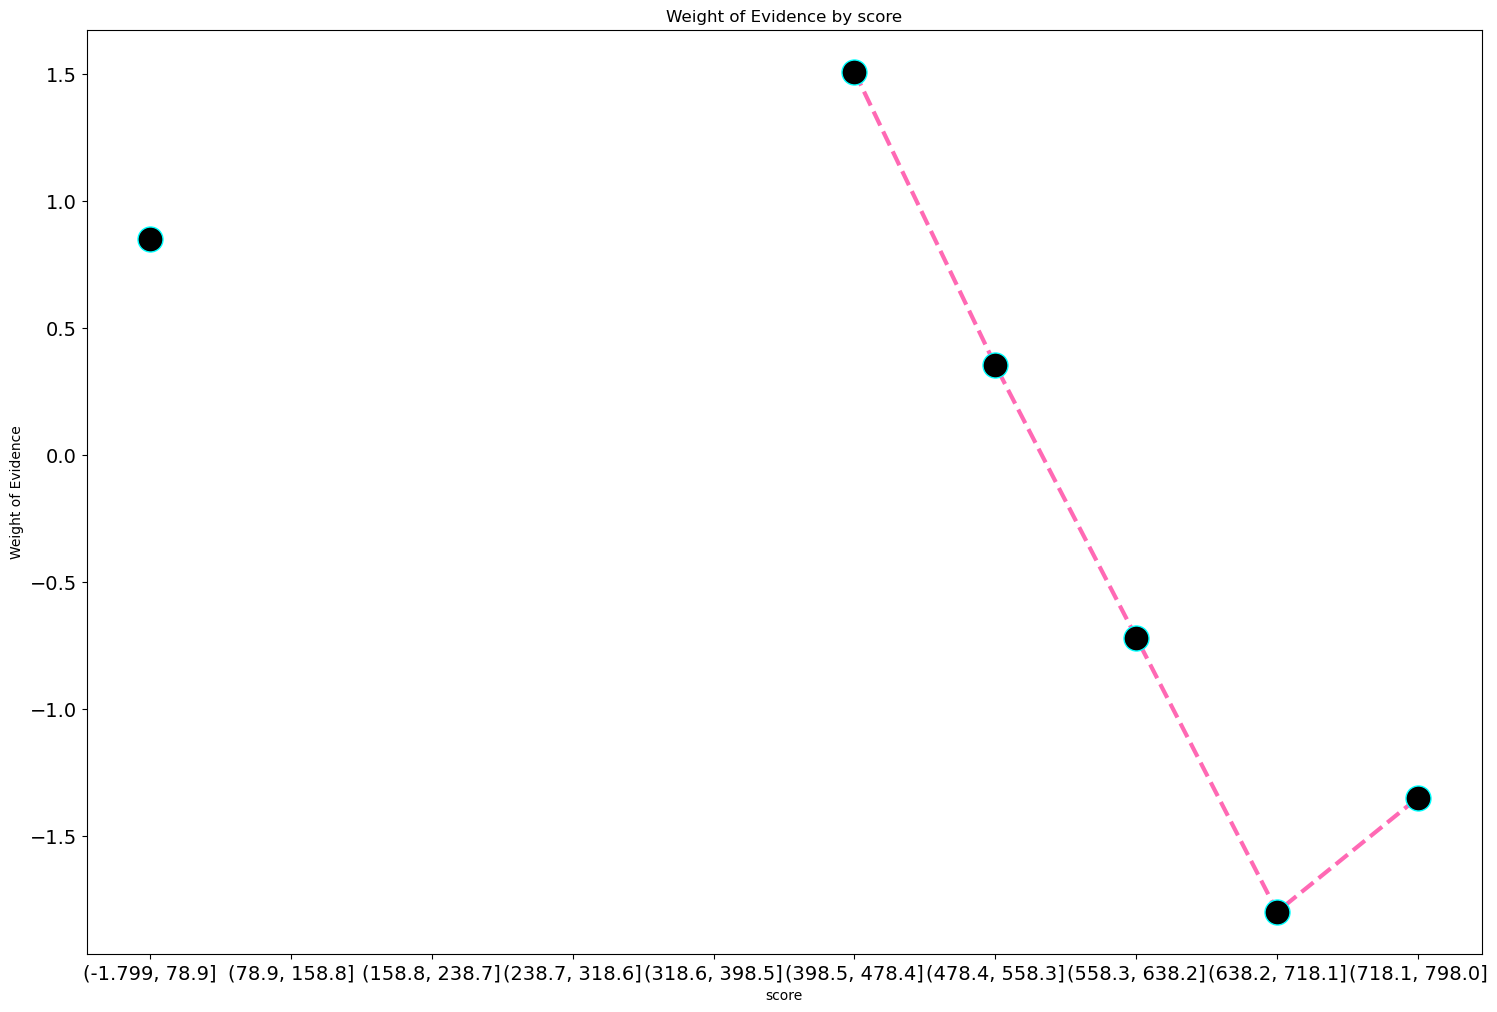

In [55]:
X['score'] = pd.cut(df['score'], 10)
age_iss_df = woe_continous(X, 'score', y)
plot_by_woe(age_iss_df)

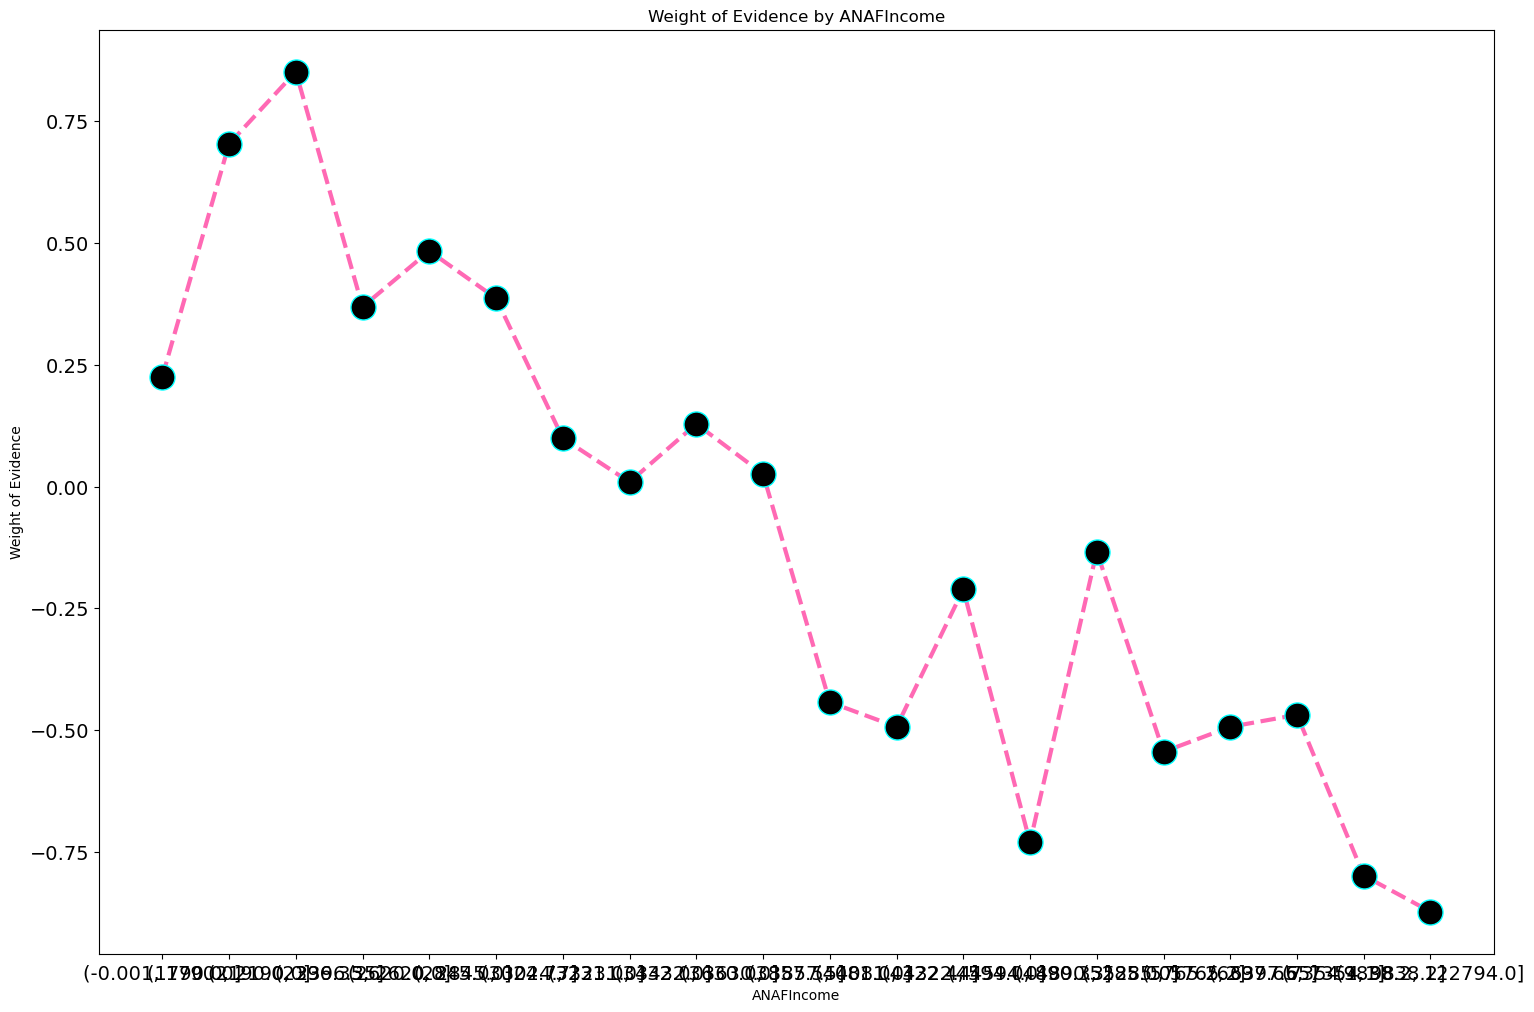

In [56]:
X['ANAFIncome'] = pd.qcut(df['ANAFIncome'], 20)
age_iss_df = woe_continous(X, 'ANAFIncome', y)
plot_by_woe(age_iss_df)

In [57]:
# X['ANAFIncome'] = pd.cut(X['ANAFIncome'], bins=20)

# income_woe_df = woe_continuous(X, 'ANAFIncome', y)

# # Plot the second round of WOE
# plot_by_woe(income_woe_df)

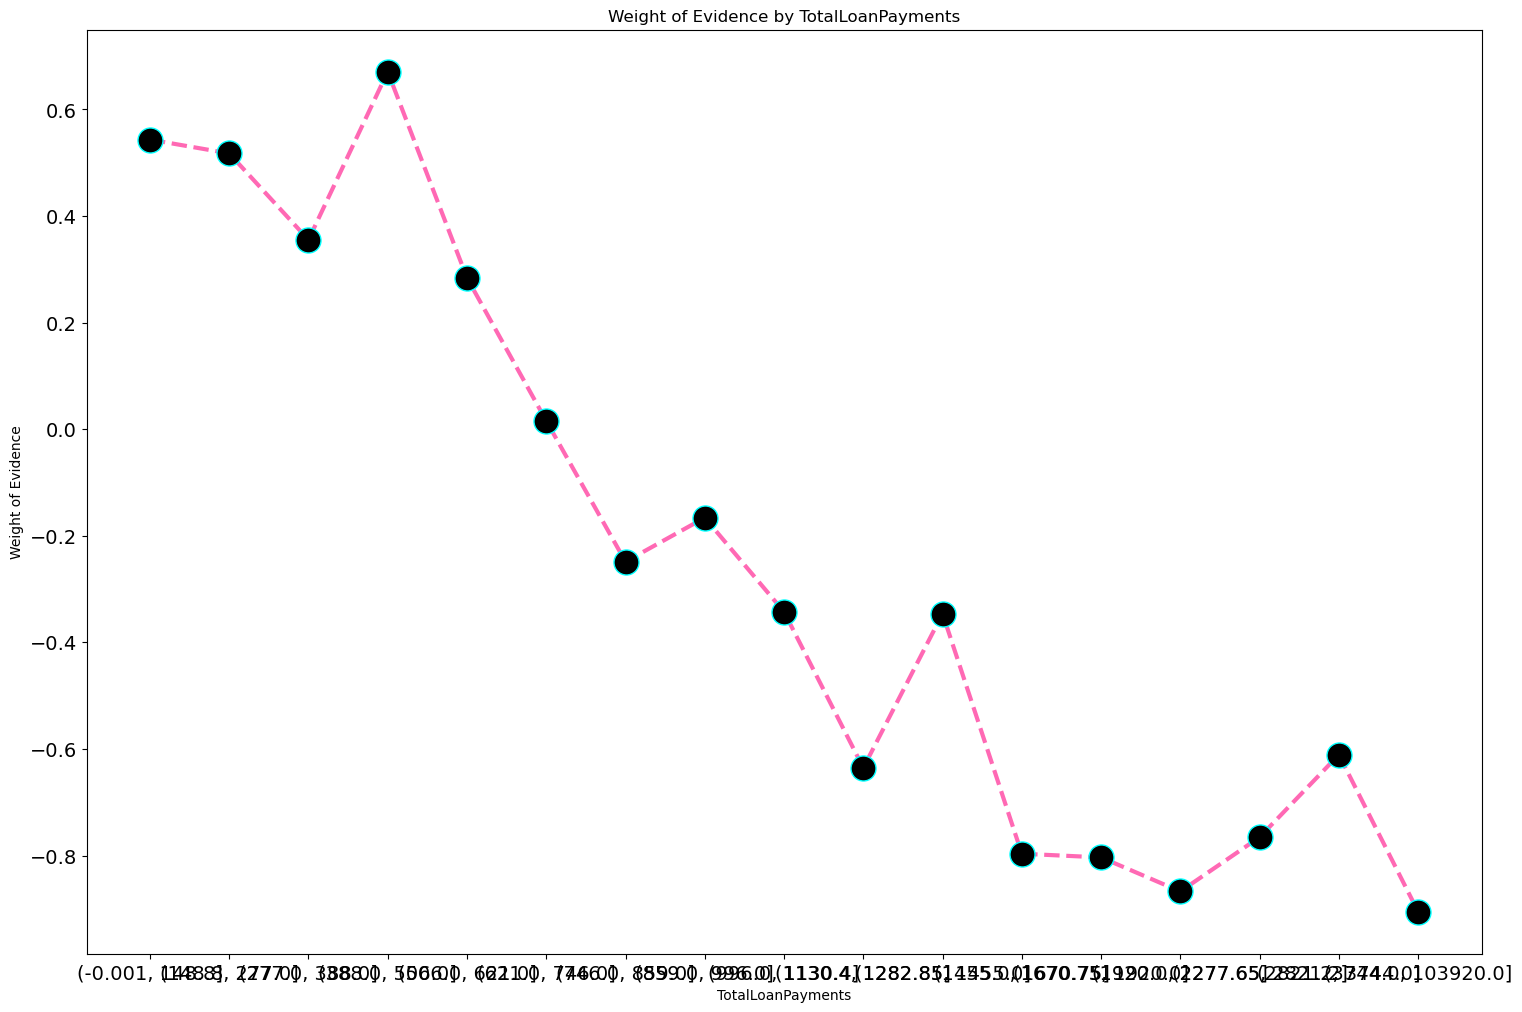

In [58]:
X['TotalLoanPayments'] = pd.qcut(df['TotalLoanPayments'], 20,duplicates='drop')
age_iss_df = woe_continous(X, 'TotalLoanPayments', y)
plot_by_woe(age_iss_df)

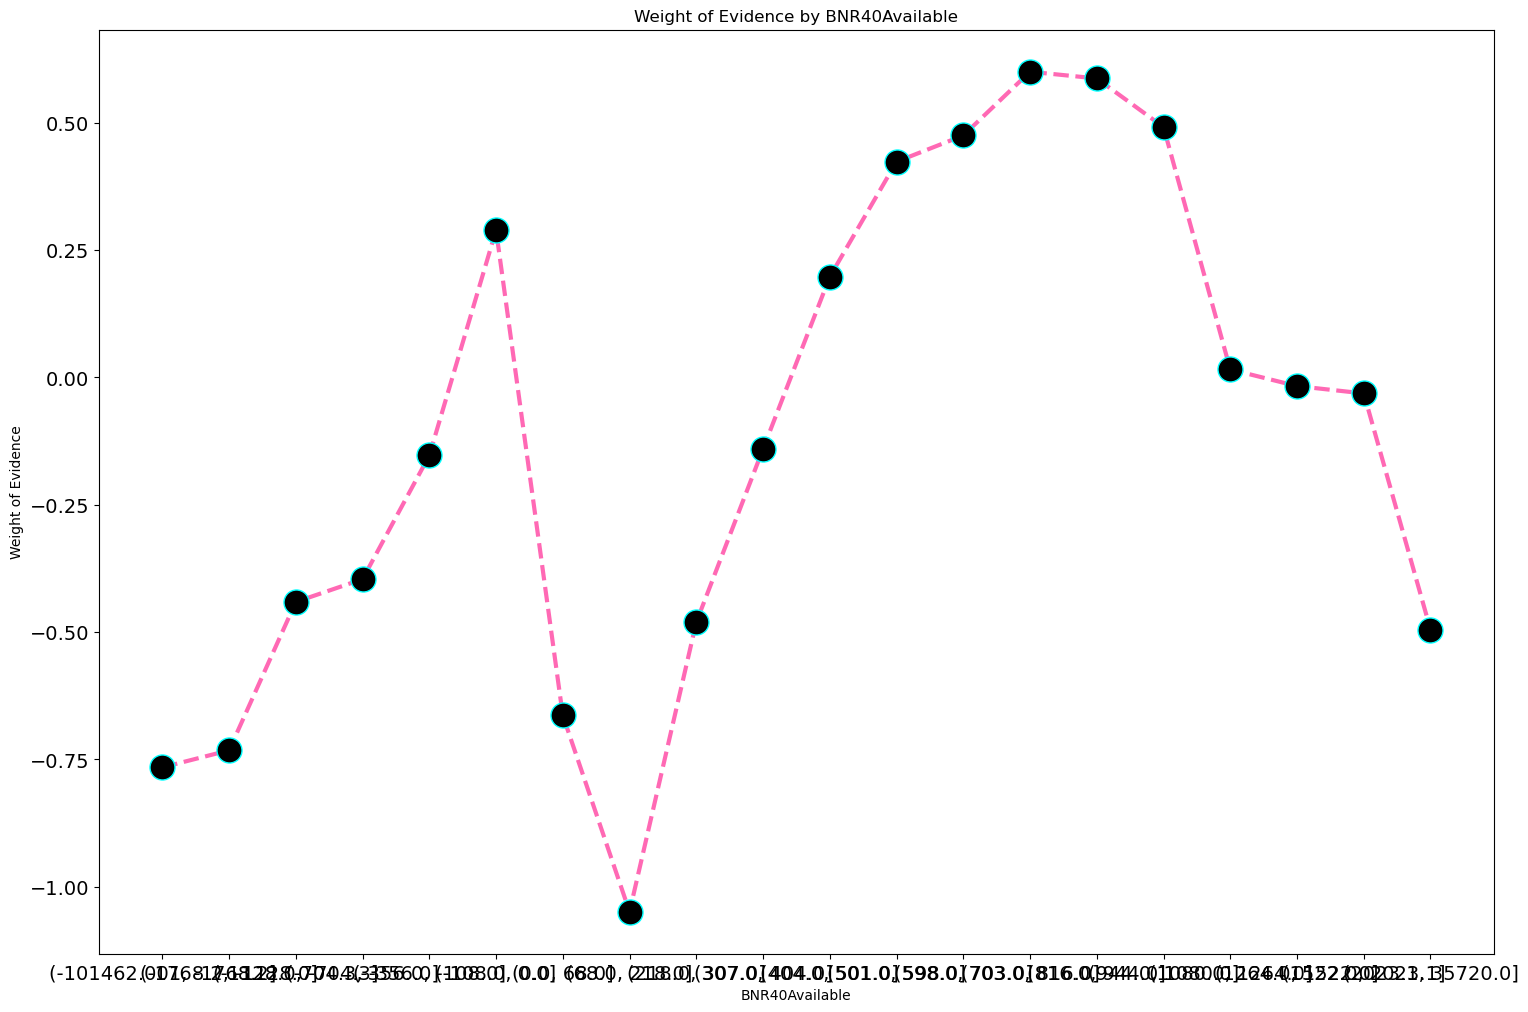

In [59]:
X['BNR40Available'] = pd.qcut(df['BNR40Available'], 20)
age_iss_df = woe_continous(X, 'BNR40Available', y)
plot_by_woe(age_iss_df)

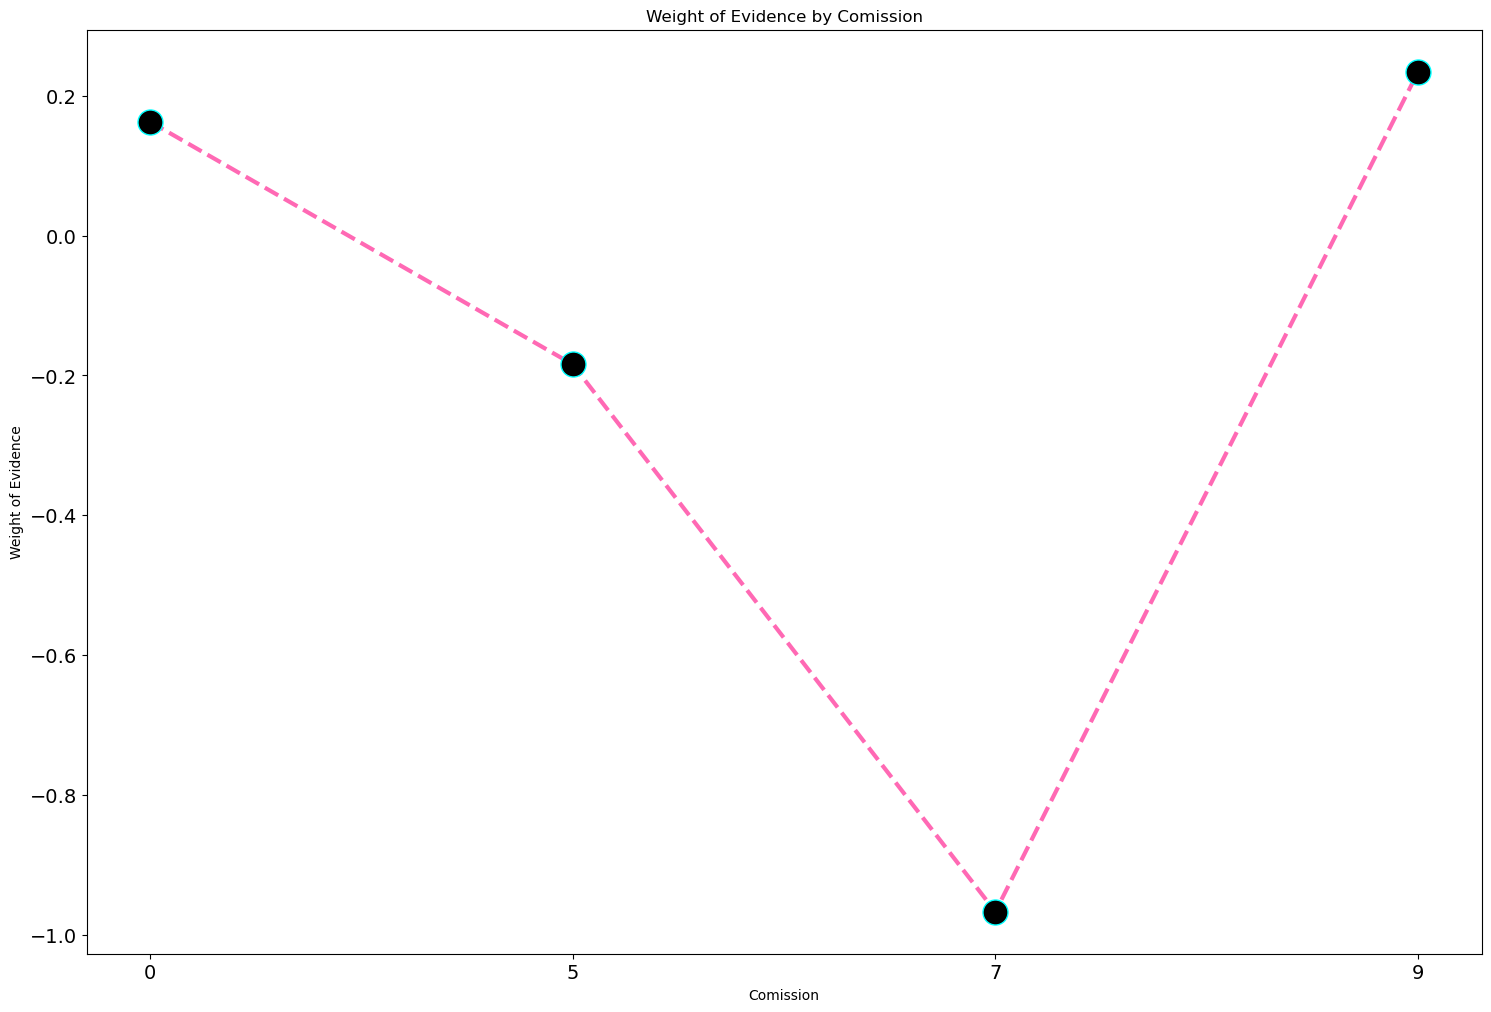

In [60]:
#X['BNR40Available'] = pd.cut(df['BNR40Available'], 100)
age_iss_df = woe_continous(X, 'Comission', y)
plot_by_woe(age_iss_df)

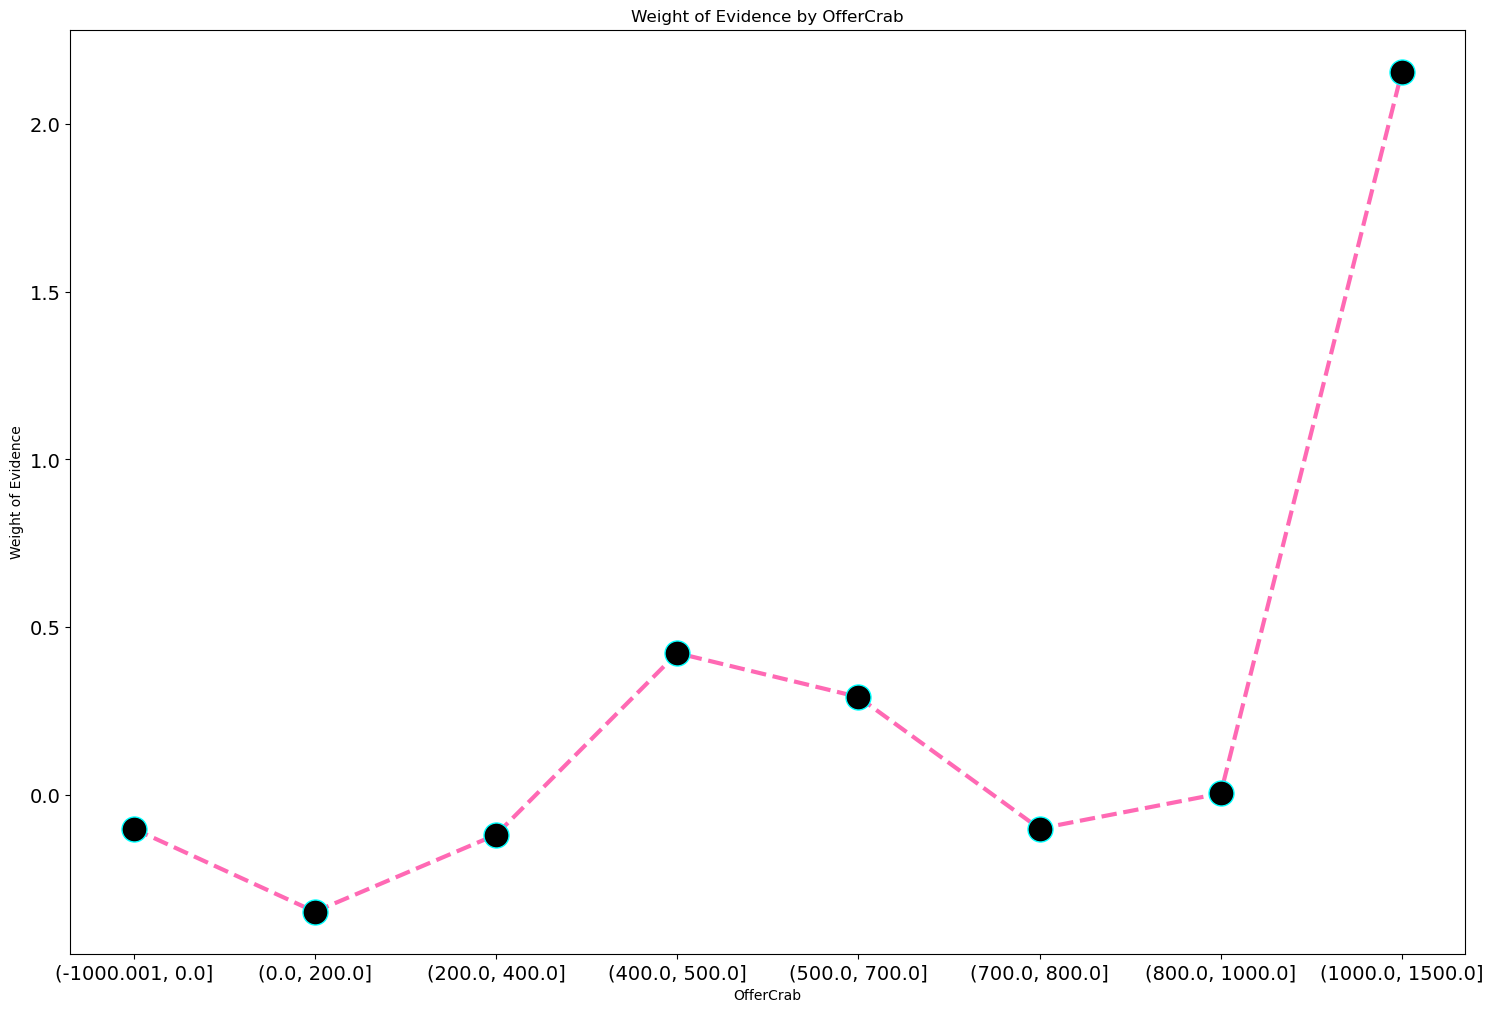

In [61]:

X['OfferCrab'] = pd.qcut(df['OfferCrab'], 10,duplicates='drop')
age_iss_df = woe_continous(X, 'OfferCrab', y)
plot_by_woe(age_iss_df)

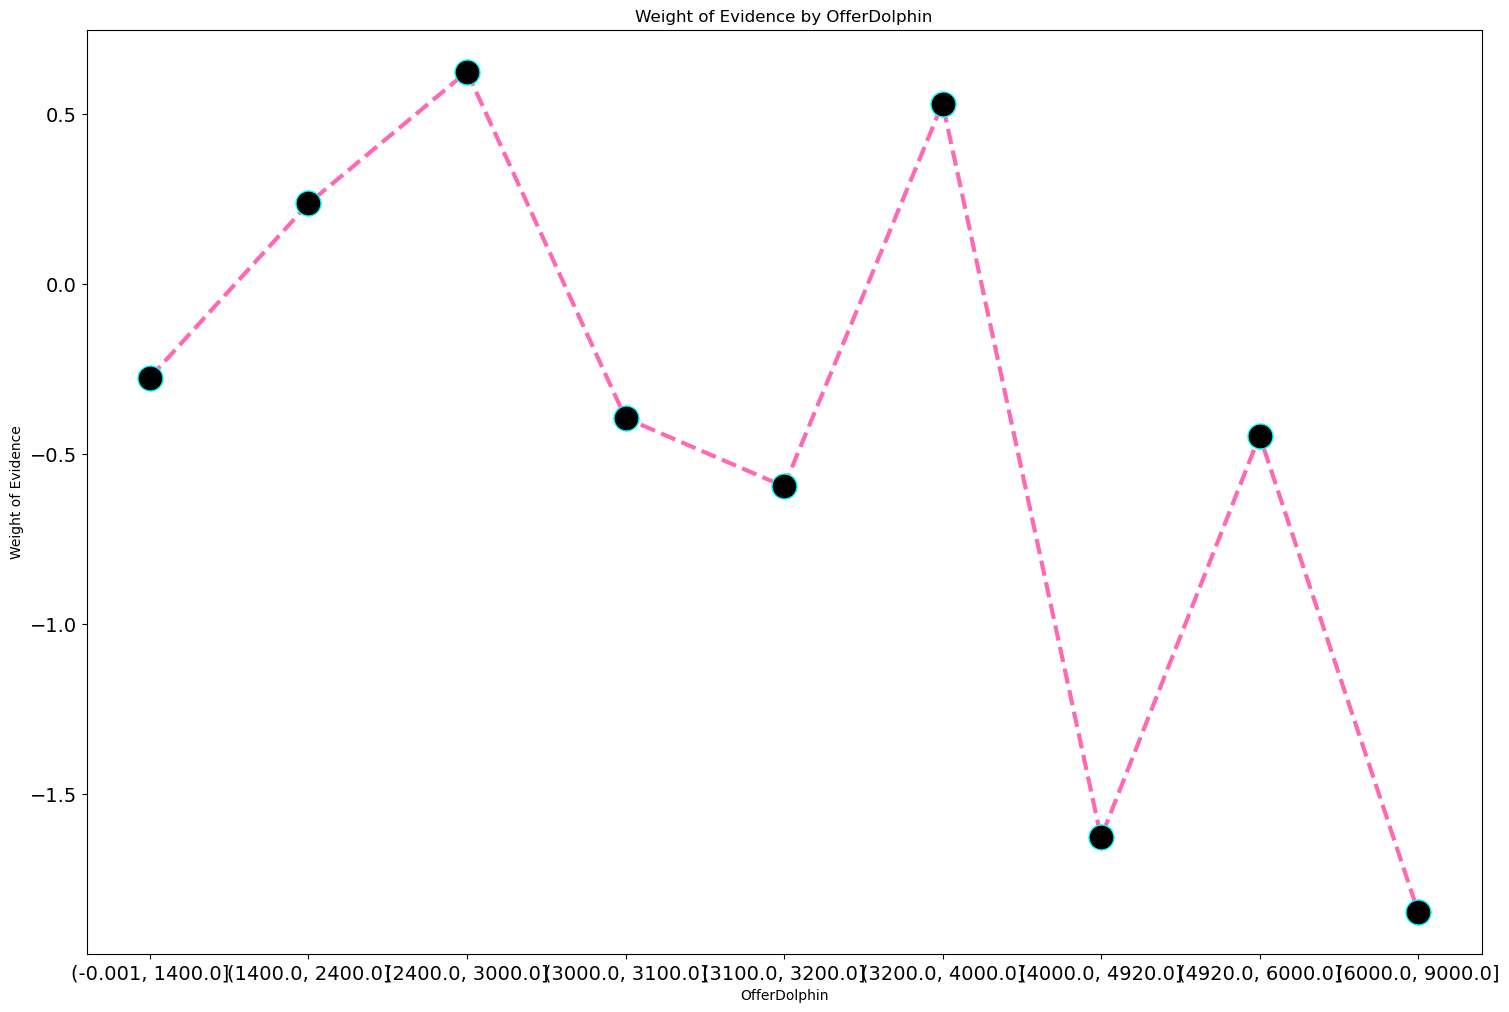

In [62]:
X['OfferDolphin'] = pd.qcut(df['OfferDolphin'], 20,duplicates='drop')
age_iss_df = woe_continous(X, 'OfferDolphin', y)
plot_by_woe(age_iss_df)

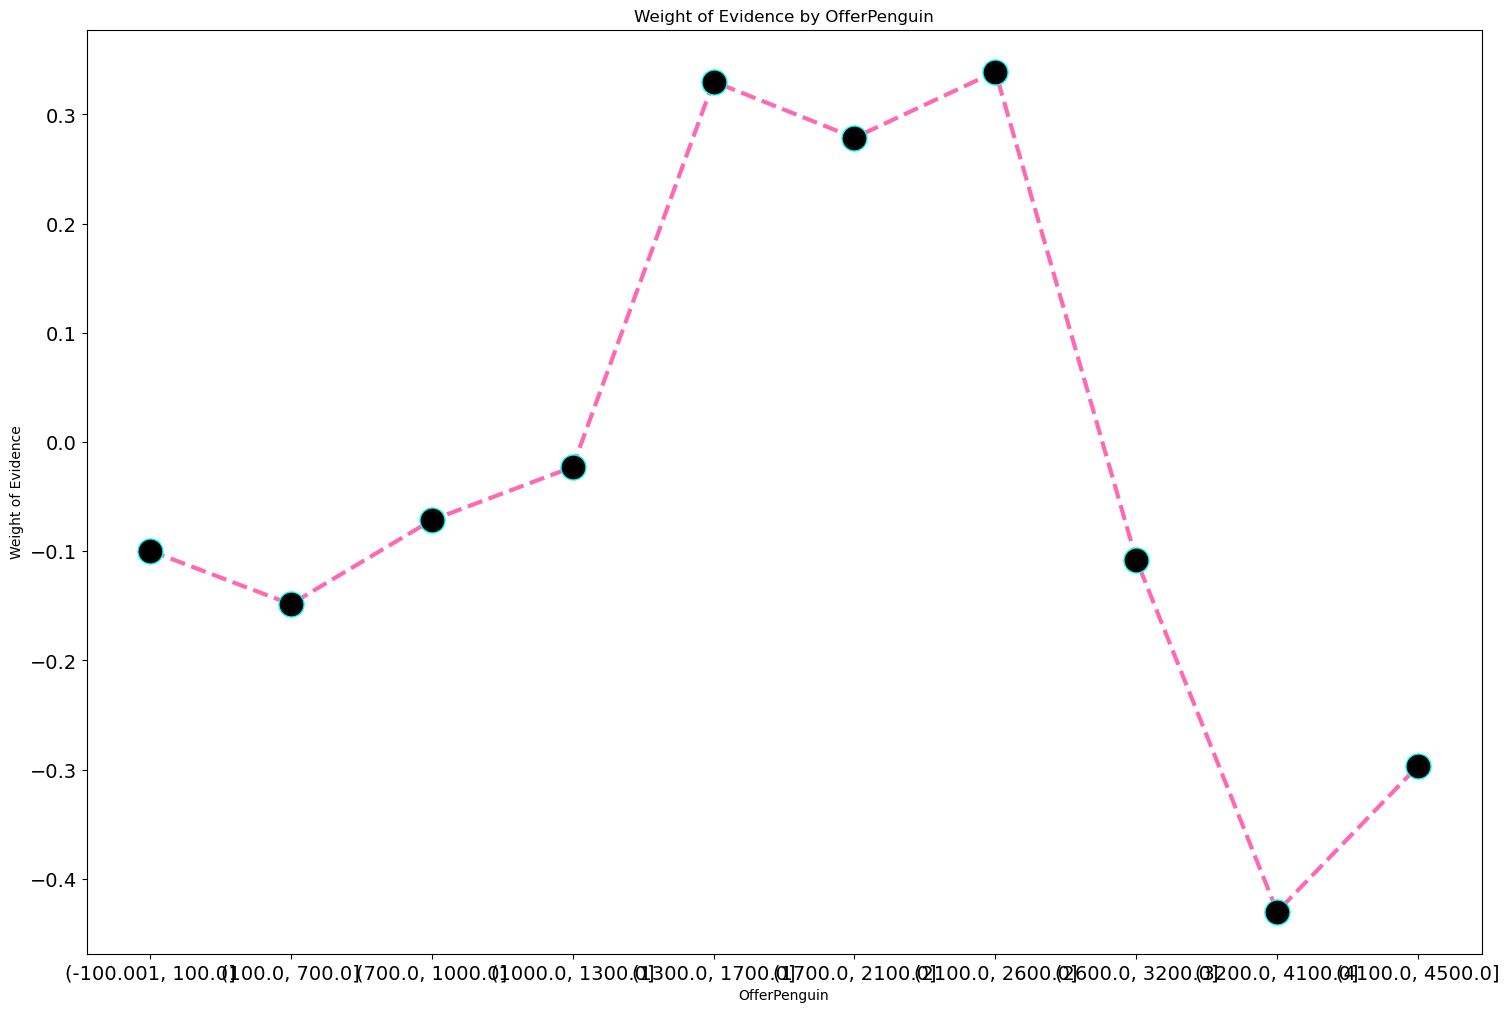

In [63]:
X['OfferPenguin'] = pd.qcut(df['OfferPenguin'], 10)
age_iss_df = woe_continous(X, 'OfferPenguin', y)
plot_by_woe(age_iss_df)

In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12110 entries, 0 to 12515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             12110 non-null  int32   
 1   Age                12110 non-null  category
 2   Produs             12110 non-null  int32   
 3   CreditLimit        12110 non-null  category
 4   score              12110 non-null  category
 5   ANAFIncome         12110 non-null  category
 6   TotalLoanPayments  12110 non-null  category
 7   BNR40Available     12110 non-null  category
 8   OfferCrab          12110 non-null  category
 9   OfferPenguin       12110 non-null  category
 10  OfferDolphin       12110 non-null  category
 11  Comission          12110 non-null  int64   
dtypes: category(9), int32(2), int64(1)
memory usage: 653.9 KB


In [65]:
X['OfferPenguin'].value_counts()

(100.0, 700.0]       1475
(1300.0, 1700.0]     1289
(-100.001, 100.0]    1253
(2600.0, 3200.0]     1241
(4100.0, 4500.0]     1210
(1700.0, 2100.0]     1182
(3200.0, 4100.0]     1141
(2100.0, 2600.0]     1129
(700.0, 1000.0]      1119
(1000.0, 1300.0]     1071
Name: OfferPenguin, dtype: int64

In [66]:
new_df=pd.DataFrame()

In [67]:
new_df['Age 23']=np.where((df['Age']<=23), 1,0)
new_df['Age 24_29'] = np.where(((df['Age'] > 23) & (df['Age'] <= 29)), 1, 0)
new_df['Age 30_34'] = np.where(((df['Age'] > 29) & (df['Age'] < 35)), 1, 0)
new_df['Age 35_40'] = np.where(((df['Age'] >= 35) & (df['Age'] <= 40)), 1, 0)
new_df['Age 41_46'] = np.where(((df['Age'] > 40) & (df['Age'] <= 46)), 1, 0)
new_df['Age 47_51'] = np.where(((df['Age'] > 46) & (df['Age'] < 52)), 1, 0)
new_df['Age 52_57'] = np.where(((df['Age'] >= 52) & (df['Age'] <= 57)), 1, 0)
new_df['Age 58_62'] = np.where(((df['Age'] > 57) & (df['Age'] <= 62)), 1, 0)
new_df['Age 63_68'] = np.where(((df['Age'] > 62) & (df['Age'] <= 68)), 1, 0)
new_df['Age 69_74'] = np.where(((df['Age'] > 68) & (df['Age'] <= 74)), 1, 0)


In [68]:
new_df.head()

,Age 23,Age 24_29,Age 30_34,Age 35_40,Age 41_46,Age 47_51,Age 52_57,Age 58_62,Age 63_68,Age 69_74
0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [69]:
new_df['CL 491_925'] = np.where(((df['CreditLimit'] > 491.5) & (df['CreditLimit'] <= 925.0)), 1, 0)
new_df['CL 925_1350'] = np.where(((df['CreditLimit'] > 925.0) & (df['CreditLimit'] <= 1350.0)), 1, 0)
new_df['CL 2625_3050'] = np.where(((df['CreditLimit'] > 2625.0) & (df['CreditLimit'] <= 3050.0)), 1, 0)
new_df['CL 3900_4325'] = np.where(((df['CreditLimit'] > 3900.0) & (df['CreditLimit'] <= 4325.0)), 1, 0)
new_df['CL 3050_3475'] = np.where(((df['CreditLimit'] > 3050.0) & (df['CreditLimit'] <= 3475.0)), 1, 0)
new_df['CL 5600_6025'] = np.where(((df['CreditLimit'] > 5600.0) & (df['CreditLimit'] <= 6025.0)), 1, 0)
new_df['CL 1775_2200'] = np.where(((df['CreditLimit'] > 1775.0) & (df['CreditLimit'] <= 2200.0)), 1, 0)
new_df['CL 1350_1775'] = np.where(((df['CreditLimit'] > 1350.0) & (df['CreditLimit'] <= 1775.0)), 1, 0)
new_df['CL 2200_2625'] = np.where(((df['CreditLimit'] > 2200.0) & (df['CreditLimit'] <= 2625.0)), 1, 0)
new_df['CL 3475_3900'] = np.where(((df['CreditLimit'] > 3475.0) & (df['CreditLimit'] <= 3900.0)), 1, 0)
new_df['CL 8575_9000'] = np.where(((df['CreditLimit'] > 8575.0) & (df['CreditLimit'] <= 9000.0)), 1, 0)
new_df['CL 4325_4750'] = np.where(((df['CreditLimit'] > 4325.0) & (df['CreditLimit'] <= 4750.0)), 1, 0)
new_df['CL 4750_5175'] = np.where(((df['CreditLimit'] > 4750.0) & (df['CreditLimit'] <= 5175.0)), 1, 0)
new_df['CL 6875_7300'] = np.where(((df['CreditLimit'] > 6875.0) & (df['CreditLimit'] <= 7300.0)), 1, 0)
new_df['CL 5175_5600'] = np.where(((df['CreditLimit'] > 5175.0) & (df['CreditLimit'] <= 5600.0)), 1, 0)
new_df['CL 6025_6450'] = np.where(((df['CreditLimit'] > 6025.0) & (df['CreditLimit'] <= 6450.0)), 1, 0)
new_df['CL 6450_6875'] = np.where(((df['CreditLimit'] > 6450.0) & (df['CreditLimit'] <= 6875.0)), 1, 0)
new_df['CL 7300_7725'] = np.where(((df['CreditLimit'] > 7300.0) & (df['CreditLimit'] <= 7725.0)), 1, 0)
new_df['CL 8150_8575'] = np.where(((df['CreditLimit'] > 8150.0) & (df['CreditLimit'] <= 8575.0)), 1, 0)
new_df['CL 7725_8150'] = np.where(((df['CreditLimit'] > 7725.0) & (df['CreditLimit'] <= 8150.0)), 1, 0)

In [70]:
new_df['score 558_638'] = np.where(((df['score'] > 558.3) & (df['score'] <= 638.2)), 1, 0)
new_df['score 638_718'] = np.where(((df['score'] > 638.2) & (df['score'] <= 718.1)), 1, 0)
new_df['score 398_478'] = np.where(((df['score'] > 398.5) & (df['score'] <= 478.4)), 1, 0)
new_df['score n1_78'] = np.where(((df['score'] > -1.799) & (df['score'] <= 78.9)), 1, 0)
new_df['score 718_798'] = np.where(((df['score'] > 718.1) & (df['score'] <= 798.0)), 1, 0)
new_df['score 78_158'] = np.where(((df['score'] > 78.9) & (df['score'] <= 158.8)), 1, 0)
new_df['score 158_238'] = np.where(((df['score'] > 158.8) & (df['score'] <= 238.7)), 1, 0)
new_df['score 238_318'] = np.where(((df['score'] > 238.7) & (df['score'] <= 318.6)), 1, 0)
new_df['score 318_398'] = np.where(((df['score'] > 318.6) & (df['score'] <= 398.5)), 1, 0)

In [71]:
new_df['ANAFIncome 2620_2845'] = np.where(((df['ANAFIncome'] > 2620.0) & (df['ANAFIncome'] <= 2845.0)), 1, 0)
new_df['ANAFIncome 3231_3432'] = np.where(((df['ANAFIncome'] > 3231.0) & (df['ANAFIncome'] <= 3432.0)), 1, 0)
new_df['ANAFIncome 4890_5285'] = np.where(((df['ANAFIncome'] > 4890.3) & (df['ANAFIncome'] <= 5285.0)), 1, 0)
new_df['ANAFIncome 3024_3231'] = np.where(((df['ANAFIncome'] > 3024.7) & (df['ANAFIncome'] <= 3231.0)), 1, 0)
new_df['ANAFIncome n0_1790'] = np.where(((df['ANAFIncome'] > -0.001) & (df['ANAFIncome'] <= 1790.0)), 1, 0)
new_df['ANAFIncome 1790_2190'] = np.where(((df['ANAFIncome'] > 1790.0) & (df['ANAFIncome'] <= 2190.0)), 1, 0)
new_df['ANAFIncome 6397_7354'] = np.where(((df['ANAFIncome'] > 6397.65) & (df['ANAFIncome'] <= 7354.1)), 1, 0)
new_df['ANAFIncome 4322_4594'] = np.where(((df['ANAFIncome'] > 4322.4) & (df['ANAFIncome'] <= 4594.0)), 1, 0)
new_df['ANAFIncome 3857_4081'] = np.where(((df['ANAFIncome'] > 3857.5) & (df['ANAFIncome'] <= 4081.0)), 1, 0)
new_df['ANAFIncome 2396_2620'] = np.where(((df['ANAFIncome'] > 2396.35) & (df['ANAFIncome'] <= 2620.0)), 1, 0)
new_df['ANAFIncome 9838_122794'] = np.where(((df['ANAFIncome'] > 9838.2) & (df['ANAFIncome'] <= 122794.0)), 1, 0)
new_df['ANAFIncome 4081_4322'] = np.where(((df['ANAFIncome'] > 4081.0) & (df['ANAFIncome'] <= 4322.4)), 1, 0)
new_df['ANAFIncome 4594_4890'] = np.where(((df['ANAFIncome'] > 4594.0) & (df['ANAFIncome'] <= 4890.3)), 1, 0)
new_df['ANAFIncome 5765_6397'] = np.where(((df['ANAFIncome'] > 5765.2) & (df['ANAFIncome'] <= 6397.65)), 1, 0)
new_df['ANAFIncome 7354_9838'] = np.where(((df['ANAFIncome'] > 7354.1) & (df['ANAFIncome'] <= 9838.2)), 1, 0)
new_df['ANAFIncome 2190_2396'] = np.where(((df['ANAFIncome'] > 2190.0) & (df['ANAFIncome'] <= 2396.35)), 1, 0)
new_df['ANAFIncome 5285_5765'] = np.where(((df['ANAFIncome'] > 5285.0) & (df['ANAFIncome'] <= 5765.2)), 1, 0)
new_df['ANAFIncome 3630_3857'] = np.where(((df['ANAFIncome'] > 3630.0) & (df['ANAFIncome'] <= 3857.5)), 1, 0)
new_df['ANAFIncome 3432_3630'] = np.where(((df['ANAFIncome'] > 3432.0) & (df['ANAFIncome'] <= 3630.0)), 1, 0)
new_df['ANAFIncome 2845_3024'] = np.where(((df['ANAFIncome'] > 2845.0) & (df['ANAFIncome'] <= 3024.7)), 1, 0)

In [72]:
new_df['TotalLoanPayments n01_148'] = np.where(((df['TotalLoanPayments'] > -0.001) & (df['TotalLoanPayments'] <= 148.8)), 1, 0)
new_df['TotalLoanPayments 621_746'] = np.where(((df['TotalLoanPayments'] > 621.0) & (df['TotalLoanPayments'] <= 746.0)), 1, 0)
new_df['TotalLoanPayments 2821_3744'] = np.where(((df['TotalLoanPayments'] > 2821.2) & (df['TotalLoanPayments'] <= 3744.0)), 1, 0)
new_df['TotalLoanPayments 148_277'] = np.where(((df['TotalLoanPayments'] > 148.8) & (df['TotalLoanPayments'] <= 277.0)), 1, 0)
new_df['TotalLoanPayments 1670_1920'] = np.where(((df['TotalLoanPayments'] > 1670.75) & (df['TotalLoanPayments'] <= 1920.0)), 1, 0)
new_df['TotalLoanPayments 1282_1455'] = np.where(((df['TotalLoanPayments'] > 1282.85) & (df['TotalLoanPayments'] <= 1455.0)), 1, 0)
new_df['TotalLoanPayments 506_621'] = np.where(((df['TotalLoanPayments'] > 506.0) & (df['TotalLoanPayments'] <= 621.0)), 1, 0)
new_df['TotalLoanPayments 277_388'] = np.where(((df['TotalLoanPayments'] > 277.0) & (df['TotalLoanPayments'] <= 388.0)), 1, 0)
new_df['TotalLoanPayments 388_506'] = np.where(((df['TotalLoanPayments'] > 388.0) & (df['TotalLoanPayments'] <= 506.0)), 1, 0)
new_df['TotalLoanPayments 2277_2821'] = np.where(((df['TotalLoanPayments'] > 2277.65) & (df['TotalLoanPayments'] <= 2821.2)), 1, 0)
new_df['TotalLoanPayments 996_1130'] = np.where(((df['TotalLoanPayments'] > 996.0) & (df['TotalLoanPayments'] <= 1130.4)), 1, 0)
new_df['TotalLoanPayments 1130_1282'] = np.where(((df['TotalLoanPayments'] > 1130.4) & (df['TotalLoanPayments'] <= 1282.85)), 1, 0)
new_df['TotalLoanPayments 1455_1670'] = np.where(((df['TotalLoanPayments'] > 1455.0) & (df['TotalLoanPayments'] <= 1670.75)), 1, 0)
new_df['TotalLoanPayments 859_996'] = np.where(((df['TotalLoanPayments'] > 859.0) & (df['TotalLoanPayments'] <= 996.0)), 1, 0)
new_df['TotalLoanPayments 1920_2277'] = np.where(((df['TotalLoanPayments'] > 1920.0) & (df['TotalLoanPayments'] <= 2277.65)), 1, 0)
new_df['TotalLoanPayments 3744_103920'] = np.where(((df['TotalLoanPayments'] > 3744.0) & (df['TotalLoanPayments'] <= 103920.0)), 1, 0)
new_df['TotalLoanPayments 746_859'] = np.where(((df['TotalLoanPayments'] > 746.0) & (df['TotalLoanPayments'] <= 859.0)), 1, 0)


In [73]:
new_df['BNR40Available n108_0'] = np.where(((df['BNR40Available'] > -108.0) & (df['BNR40Available'] <= 0.0)), 1, 0)
new_df['BNR40Available 816_944'] = np.where(((df['BNR40Available'] > 816.0) & (df['BNR40Available'] <= 944.0)), 1, 0)
new_df['BNR40Available 68_218'] = np.where(((df['BNR40Available'] > 68.0) & (df['BNR40Available'] <= 218.0)), 1, 0)
new_df['BNR40Available 598_703'] = np.where(((df['BNR40Available'] > 598.0) & (df['BNR40Available'] <= 703.0)), 1, 0)
new_df['BNR40Available n704_n356'] = np.where(((df['BNR40Available'] > -704.3) & (df['BNR40Available'] <= -356.0)), 1, 0)
new_df['BNR40Available n356_n108'] = np.where(((df['BNR40Available'] > -356.0) & (df['BNR40Available'] <= -108.0)), 1, 0)
new_df['BNR40Available n101462_1768'] = np.where(((df['BNR40Available'] > -101462.001) & (df['BNR40Available'] <= -1768.2)), 1, 0)
new_df['BNR40Available n1768_1128'] = np.where(((df['BNR40Available'] > -1768.2) & (df['BNR40Available'] <= -1128.0)), 1, 0)
new_df['BNR40Available 1264_1522'] = np.where(((df['BNR40Available'] > 1264.0) & (df['BNR40Available'] <= 1522.0)), 1, 0)
new_df['BNR40Available 404_501'] = np.where(((df['BNR40Available'] > 404.0) & (df['BNR40Available'] <= 501.0)), 1, 0)
new_df['BNR40Available 2023_35720'] = np.where(((df['BNR40Available'] > 2023.1) & (df['BNR40Available'] <= 35720.0)), 1, 0)
new_df['BNR40Available 501_598'] = np.where(((df['BNR40Available'] > 501.0) & (df['BNR40Available'] <= 598.0)), 1, 0)
new_df['BNR40Available n1128_n704'] = np.where(((df['BNR40Available'] > -1128.0) & (df['BNR40Available'] <= -704.3)), 1, 0)
new_df['BNR40Available 1522_2023'] = np.where(((df['BNR40Available'] > 1522.0) & (df['BNR40Available'] <= 2023.1)), 1, 0)
new_df['BNR40Available 703_816'] = np.where(((df['BNR40Available'] > 703.0) & (df['BNR40Available'] <= 816.0)), 1, 0)
new_df['BNR40Available 307_404'] = np.where(((df['BNR40Available'] > 307.0) & (df['BNR40Available'] <= 404.0)), 1, 0)
new_df['BNR40Available 218_307'] = np.where(((df['BNR40Available'] > 218.0) & (df['BNR40Available'] <= 307.0)), 1, 0)
new_df['BNR40Available 1080_1264'] = np.where(((df['BNR40Available'] > 1080.0) & (df['BNR40Available'] <= 1264.0)), 1, 0)
new_df['BNR40Available 944_1080'] = np.where(((df['BNR40Available'] > 944.0) & (df['BNR40Available'] <= 1080.0)), 1, 0)
new_df['BNR40Available 0_68'] = np.where(((df['BNR40Available'] > 0.0) & (df['BNR40Available'] <= 68.0)), 1, 0)

In [74]:
new_df['OfferCrab 800_1000'] = np.where(((df['OfferCrab'] > 800.0) & (df['OfferCrab'] <= 1000.0)), 1, 0)
new_df['OfferCrab 200_400'] = np.where(((df['OfferCrab'] > 200.0) & (df['OfferCrab'] <= 400.0)), 1, 0)
new_df['OfferCrab 0_200'] = np.where(((df['OfferCrab'] > 0.0) & (df['OfferCrab'] <= 200.0)), 1, 0)
new_df['OfferCrab n1000_0'] = np.where(((df['OfferCrab'] > -1000.001) & (df['OfferCrab'] <= 0.0)), 1, 0)
new_df['OfferCrab 500_700'] = np.where(((df['OfferCrab'] > 500.0) & (df['OfferCrab'] <= 700.0)), 1, 0)
new_df['OfferCrab 700_800'] = np.where(((df['OfferCrab'] > 700.0) & (df['OfferCrab'] <= 800.0)), 1, 0)
new_df['OfferCrab 400_500'] = np.where(((df['OfferCrab'] > 400.0) & (df['OfferCrab'] <= 500.0)), 1, 0)
new_df['OfferCrab 1000_1500'] = np.where(((df['OfferCrab'] > 1000.0) & (df['OfferCrab'] <= 1500.0)), 1, 0)


In [75]:
new_df['OfferDolphin 0_1400'] = np.where(((df['OfferDolphin'] > -0.001) & (df['OfferDolphin'] <= 1400.0)), 1, 0)
new_df['OfferDolphin 3200_4000'] = np.where(((df['OfferDolphin'] > 3200.0) & (df['OfferDolphin'] <= 4000.0)), 1, 0)
new_df['OfferDolphin 2400_3000'] = np.where(((df['OfferDolphin'] > 2400.0) & (df['OfferDolphin'] <= 3000.0)), 1, 0)
new_df['OfferDolphin 4920_6000'] = np.where(((df['OfferDolphin'] > 4920.0) & (df['OfferDolphin'] <= 6000.0)), 1, 0)
new_df['OfferDolphin 6000_9000'] = np.where(((df['OfferDolphin'] > 6000.0) & (df['OfferDolphin'] <= 9000.0)), 1, 0)
new_df['OfferDolphin 3100_3200'] = np.where(((df['OfferDolphin'] > 3100.0) & (df['OfferDolphin'] <= 3200.0)), 1, 0)
new_df['OfferDolphin 1400_2400'] = np.where(((df['OfferDolphin'] > 1400.0) & (df['OfferDolphin'] <= 2400.0)), 1, 0)
new_df['OfferDolphin 4000_4920'] = np.where(((df['OfferDolphin'] > 4000.0) & (df['OfferDolphin'] <= 4920.0)), 1, 0)
new_df['OfferDolphin 3000_3100'] = np.where(((df['OfferDolphin'] > 3000.0) & (df['OfferDolphin'] <= 3100.0)), 1, 0)


In [76]:
new_df['OfferPenguin 100700'] = np.where(((df['OfferPenguin'] > 100.0) & (df['OfferPenguin'] <= 700.0)), 1, 0)
new_df['OfferPenguin 1300_1700'] = np.where(((df['OfferPenguin'] > 1300.0) & (df['OfferPenguin'] <= 1700.0)), 1, 0)
new_df['OfferPenguin n100_100'] = np.where(((df['OfferPenguin'] > -100.001) & (df['OfferPenguin'] <= 100.0)), 1, 0)
new_df['OfferPenguin 2600_3200'] = np.where(((df['OfferPenguin'] > 2600.0) & (df['OfferPenguin'] <= 3200.0)), 1, 0)
new_df['OfferPenguin_4100_4500'] = np.where(((df['OfferPenguin'] > 4100.0) & (df['OfferPenguin'] <= 4500.0)), 1, 0)
new_df['OfferPenguin_1700_2100'] = np.where(((df['OfferPenguin'] > 1700.0) & (df['OfferPenguin'] <= 2100.0)), 1, 0)
new_df['OfferPenguin_3200_4100'] = np.where(((df['OfferPenguin'] > 3200.0) & (df['OfferPenguin'] <= 4100.0)), 1, 0)
new_df['OfferPenguin_2100_2600'] = np.where(((df['OfferPenguin'] > 2100.0) & (df['OfferPenguin'] <= 2600.0)), 1, 0)
new_df['OfferPenguin_700_1000'] = np.where(((df['OfferPenguin'] > 700.0) & (df['OfferPenguin'] <= 1000.0)), 1, 0)
new_df['OfferPenguin_1000_1300'] = np.where(((df['OfferPenguin'] > 1000.0) & (df['OfferPenguin'] <= 1300.0)), 1, 0)


In [77]:
new_df.shape

(12110, 123)

In [78]:
# dummy_df_pr = pd.get_dummies(dataset['Produs'])
# dummy_df_gn = pd.get_dummies(dataset['Gender'])
# dummy_df_cm = pd.get_dummies(dataset['Comission'])
# new_df= pd.concat([dummy_df_pr,dummy_df_gn,dummy_df_cm,new_df], axis=1)
# new_df=new_df.drop(["Produs","Gender","Comission"],axis=1)

In [79]:
new_df.shape

(12110, 123)

In [80]:
new_df=new_df.dropna()

In [81]:
new_df.shape

(12110, 123)

In [82]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(new_df, y)

In [83]:
new_df = new_df.rename(columns=lambda x: x.replace(' ', '_'))
new_df = new_df.rename(columns=lambda x: x.replace(':', '_'))


              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      2177
         1.0       0.95      0.91      0.93      2164

    accuracy                           0.93      4341
   macro avg       0.93      0.93      0.93      4341
weighted avg       0.93      0.93      0.93      4341



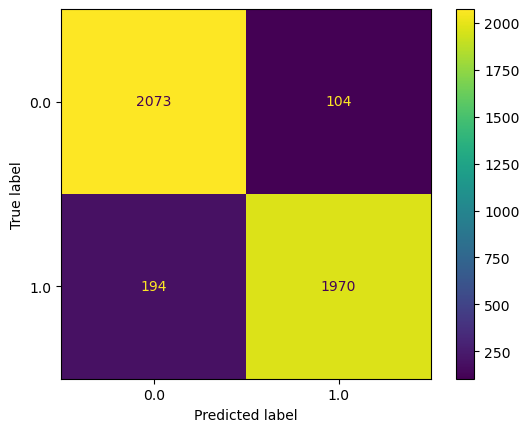

In [84]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train, y_train)
y_pred = lgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

In [85]:
y_hat_test_proba = lgb_classifier.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba), pd.DataFrame(y_pred)], axis = 1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba,y_hat_test
8528,0.0,0.043475,0.0
20469,1.0,0.970418,1.0
4985,0.0,0.009317,0.0
17516,1.0,0.980201,1.0
2534,0.0,0.252407,0.0


Text(0.5, 1.0, 'ROC curve')

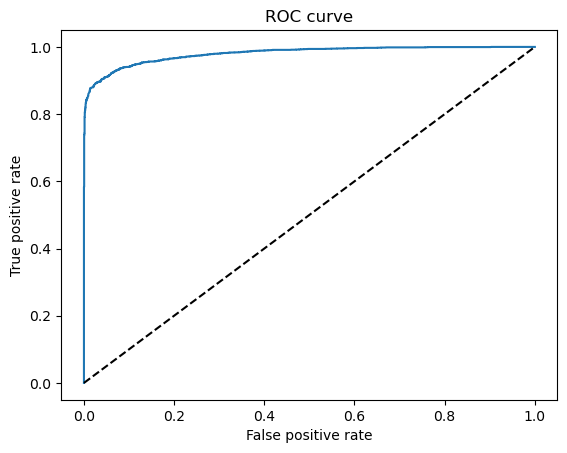

In [89]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [90]:
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.9800680445966359

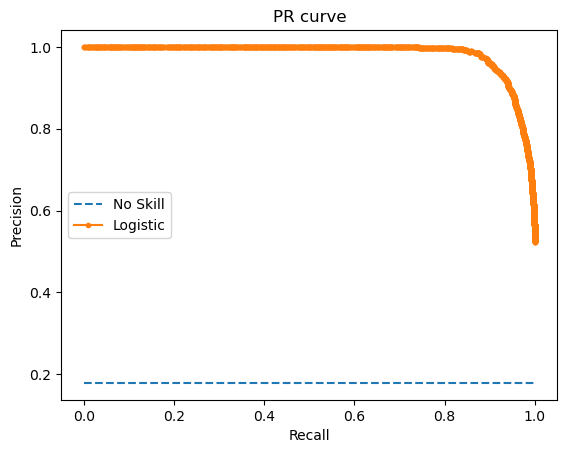

In [91]:
from sklearn.metrics import precision_recall_curve, auc

# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [92]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [93]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

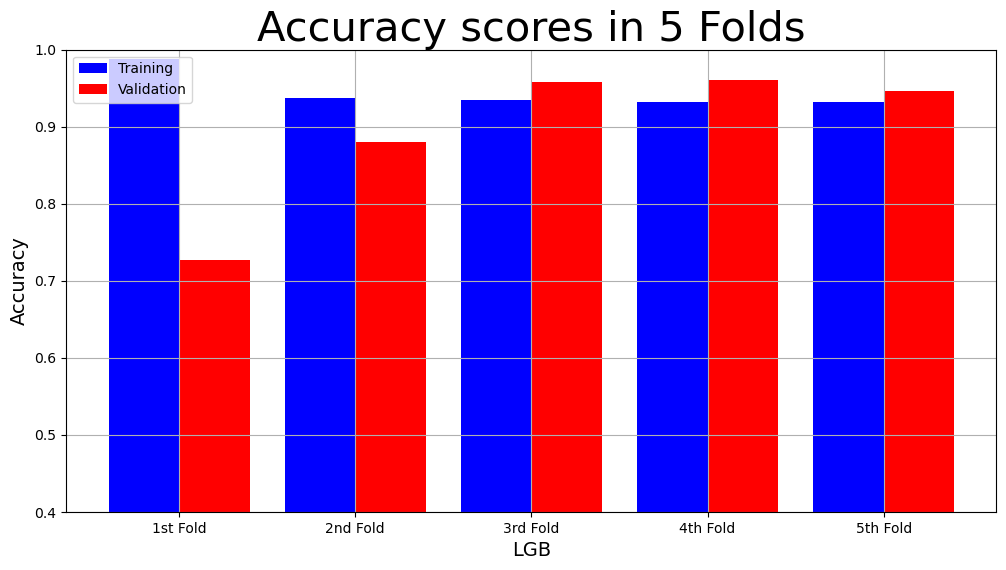

In [94]:
from sklearn.model_selection import cross_validate
lgb_result = cross_validation(lgb_classifier, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

In [96]:
# import pickle
# with open('credit_risk model.pkl', 'wb') as file:
#     pickle.dump(lgb_classifier, file)